# Anomaly Detection and RUL Prediction - Engine Dataset

### Here, in this usecase, we've three objectives such as 
1. Anomaly Detection
2. RUL Prediction
3. Feature Importance 

### Import libraries

In [930]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


### Read the dataset
Here, we've 100 files where each file represents each unique engine unit. So,we're merging all the 100 files into one single dataframe for analysis purpose.

In [608]:
# df is empty dataframe where we'll be appending all the 100 files dataset into it.
df=pd.DataFrame()
for i in glob.glob('/Users/nirmalnk/Documents/Sim Eng Data/*.csv'):
    df1=pd.read_csv(i)
    #print("df1 shape",df1.shape)
    #print(df1.columns)
    df=df.append(df1)

# Post append, we can see the 20231 rows and 16 columns in total.
print('Final dtaframe shape is' ,df.shape)

Final dtaframe shape is (20231, 16)


In [187]:
# 100 unique engine untis, verifying it
df.Unit.unique().size

100

In [188]:
# Exploring what are the dataset features 
# we can see 14 different sensors and unit represnts engine unit and Time represnts cycle
print('Dataset features are listed below : \n' , df.columns)

Dataset features are listed below : 
 Index(['Unit', 'Time', 'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp',
       'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed',
       'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed',
       'BypassRatio', 'BleedEnthalpy', 'HPTCoolantBleed', 'LPTCoolantBleed'],
      dtype='object')


In [190]:
# dataframe statitics summary
meta_df=pd.DataFrame(df.describe())
meta_df

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed
count,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000,20231.000000
mean,51.526469,110.909742,642.673752,1590.442852,1408.793569,553.380808,2388.095618,9064.999267,47.536932,521.424917,2388.095114,8143.581095,8.441585,393.189650,38.818872,23.291248
std,29.234387,67.900688,0.410019,4.858660,8.026972,0.786600,0.064060,20.965647,0.244534,0.669233,0.064938,18.196445,0.032079,1.260893,0.152329,0.091577
min,1.000000,5.000000,641.616000,1576.244000,1390.278000,550.810000,2387.954000,9027.652000,47.028000,519.224000,2387.946000,8103.466000,8.367020,390.000000,38.326000,23.011400
25%,26.000000,55.000000,642.372000,1586.926000,1402.748000,552.922000,2388.046000,9053.908000,47.352000,521.034000,2388.046000,8133.408000,8.417220,392.200000,38.728000,23.237110
50%,52.000000,106.000000,642.630000,1589.826000,1407.828000,553.450000,2388.094000,9060.352000,47.512000,521.478000,2388.092000,8140.524000,8.438120,393.000000,38.836000,23.300420
75%,77.000000,158.000000,642.924000,1593.276000,1413.642000,553.982000,2388.134000,9068.542000,47.682000,521.936000,2388.134000,8147.898000,8.460600,394.000000,38.932000,23.359390
max,100.000000,362.000000,644.020000,1608.070000,1432.984000,555.174000,2388.326000,9223.844000,48.274000,522.970000,2388.338000,8281.152000,8.542420,397.600000,39.186000,23.507160


From the above statistics summary of dataframe, we can see  PhysFanSpeed and CorrFanSpeed have similar distribution values
Also, features PhysCoreSpeed and  CorrCoreSpeed have similar distribution values.

High chances of highly correlated. Later, will verify by performing correlation plot.
If it is true, will skip these columns for further analysis.

### Data preprocessing

Checking missing values

In [191]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]
# Let's use above function to look at top ten columns with NaNs
calc_percent_NAs(df).head(15)

,percent


In [192]:
df.isnull().sum()


Unit                   0
Time                   0
LPCOutletTemp          0
HPCOutletTemp          0
LPTOutletTemp          0
TotalHPCOutletPres     0
PhysFanSpeed           0
PhysCoreSpeed          0
StaticHPCOutletPres    0
FuelFlowRatio          0
CorrFanSpeed           0
CorrCoreSpeed          0
BypassRatio            0
BleedEnthalpy          0
HPTCoolantBleed        0
LPTCoolantBleed        0
dtype: int64

We can see there are are no missing values in the given dataset. So not required much data imputation.

### Exploratory Data Analysis

#### Plot on Cycle Time for each engine unit

<ipython-input-53-bb31d2cd5947>:10: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


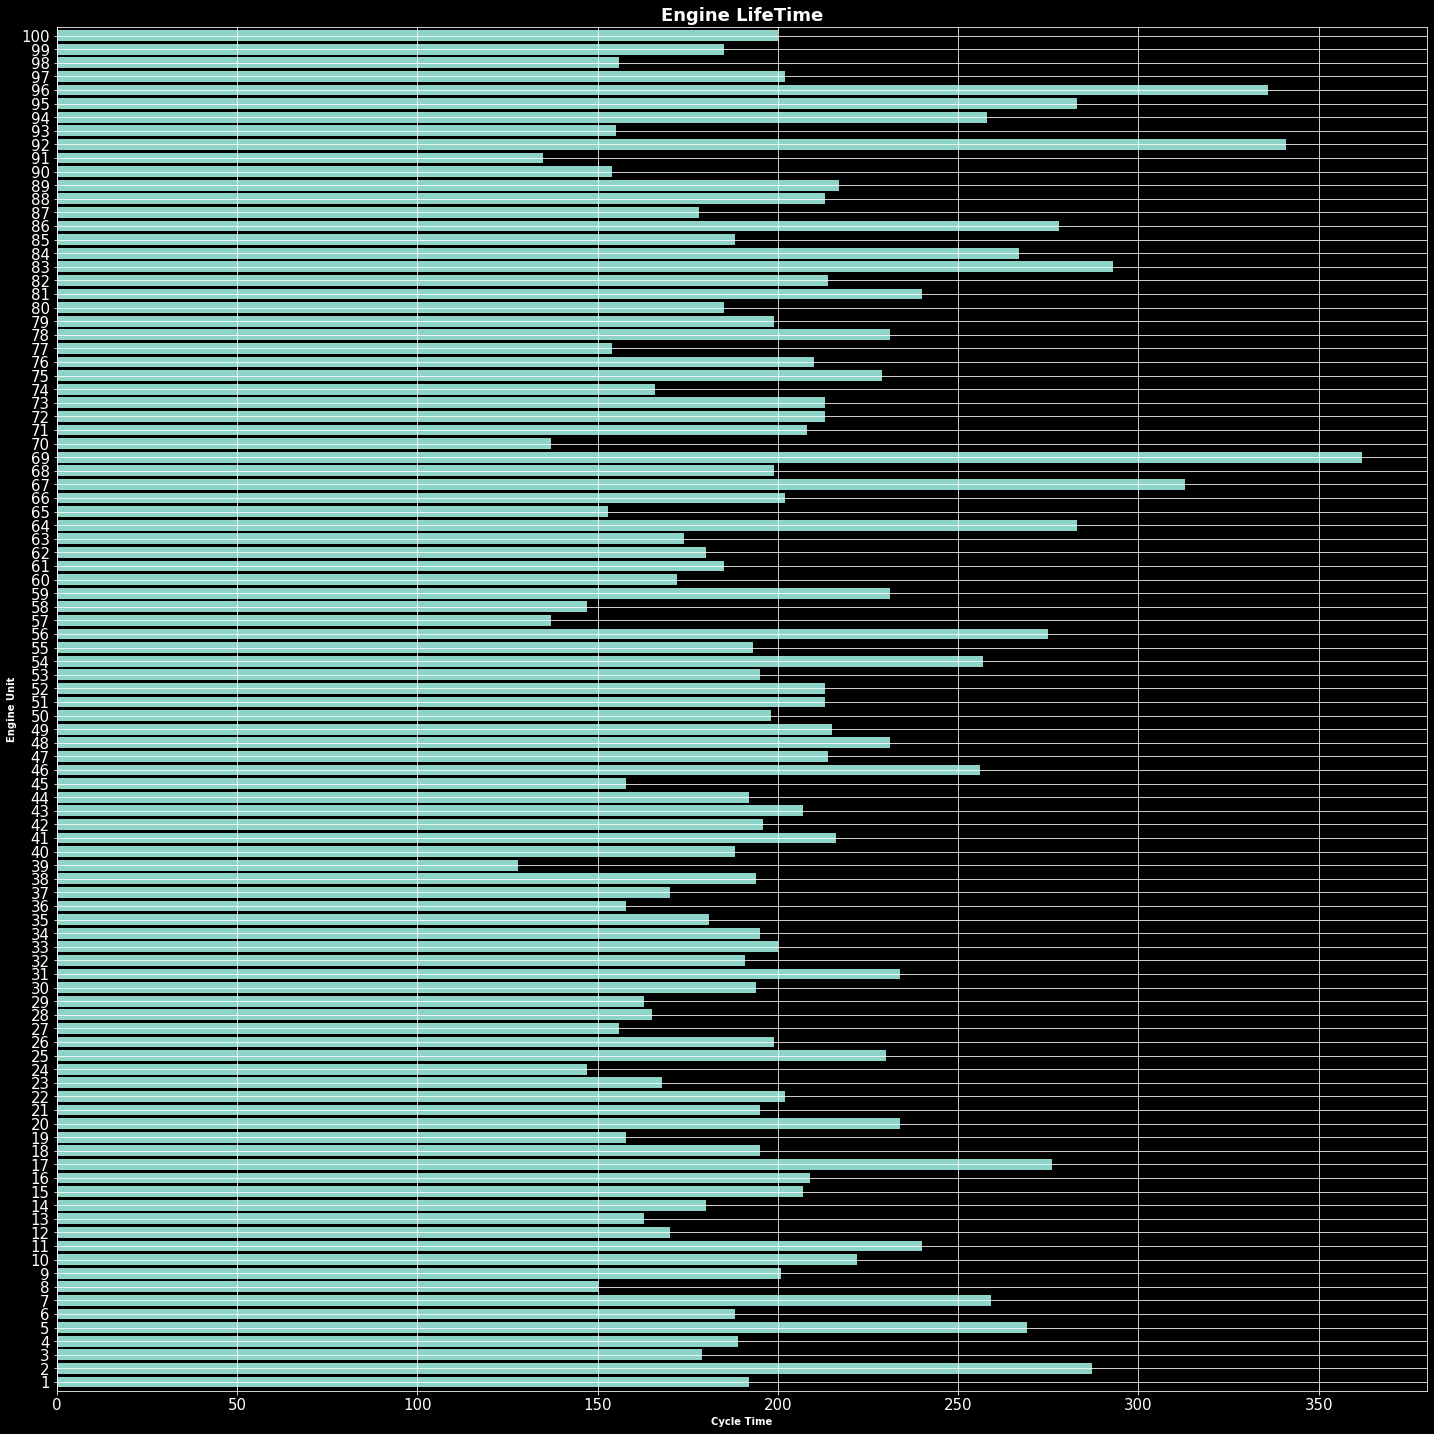

In [53]:
plt.style.use('dark_background')
plt.figure(figsize=(20,20))
ax=df.groupby('Unit')['Time'].max().plot(kind='barh',width=0.8, stacked=True,align='center',rot=0)
plt.title('Engine LifeTime',fontweight='bold',size=18)
plt.xlabel('Cycle Time',fontweight='bold',size=10)
plt.xticks(size=15)
plt.ylabel('Engine Unit',fontweight='bold',size=10)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout(True)
plt.show()

Histogram on Cycle Time

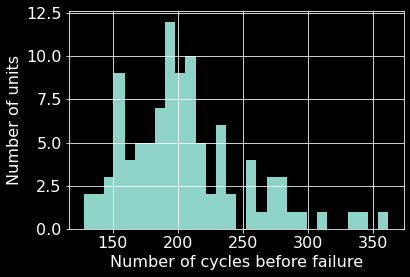

In [166]:
fig, ax = plt.subplots()
df.groupby("Unit")['Time'].max().hist (ax =ax, bins =30);
ax.set_xlabel("Number of cycles before failure");
ax.set_ylabel("Number of units");

From above graph, we can see most of engine units having average of 200 - 220 cycle time

#### Visualizing all sensors on one Engine Unit

Here, we're visualizing all the sensors of engine unit 1

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

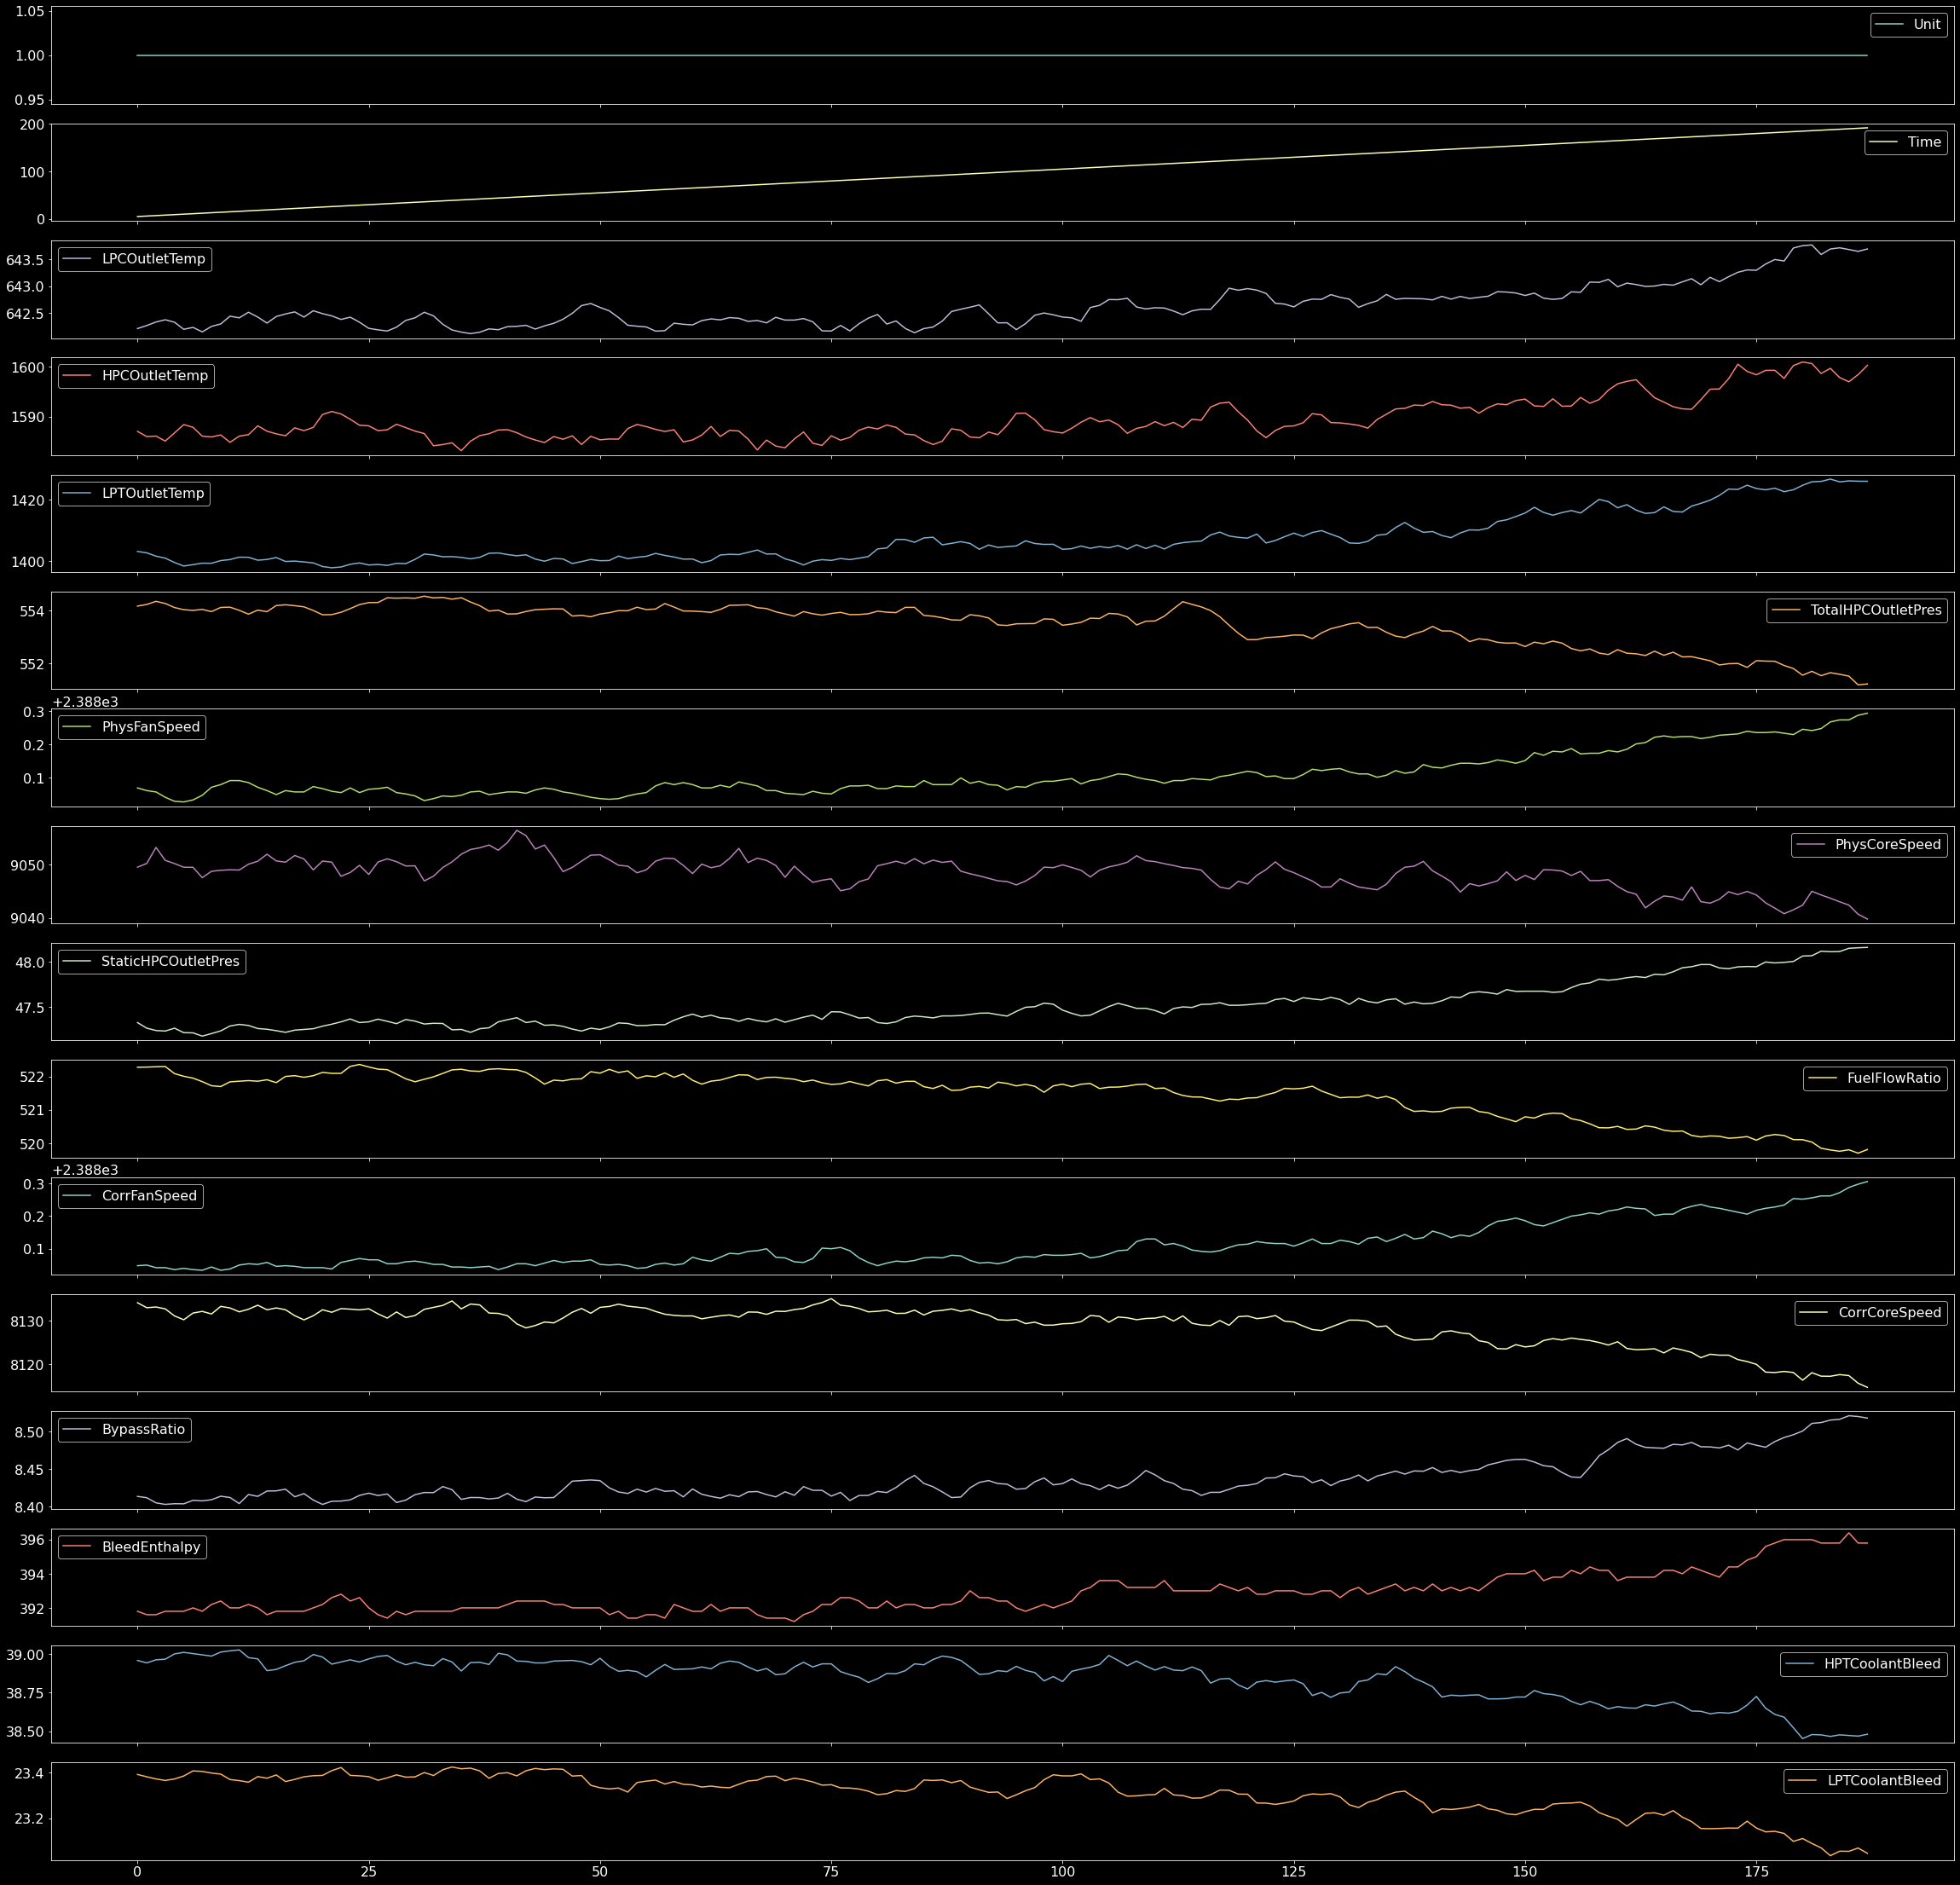

In [193]:
df[df.Unit == 1].plot(subplots =True, sharex =True, figsize = (40,40))


#### Visualizing one sensors  of all engine units


Here, we visulaized the 'PhysCoreSpeed' sensor through box plot

<ipython-input-161-fa9fa58f3c10>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


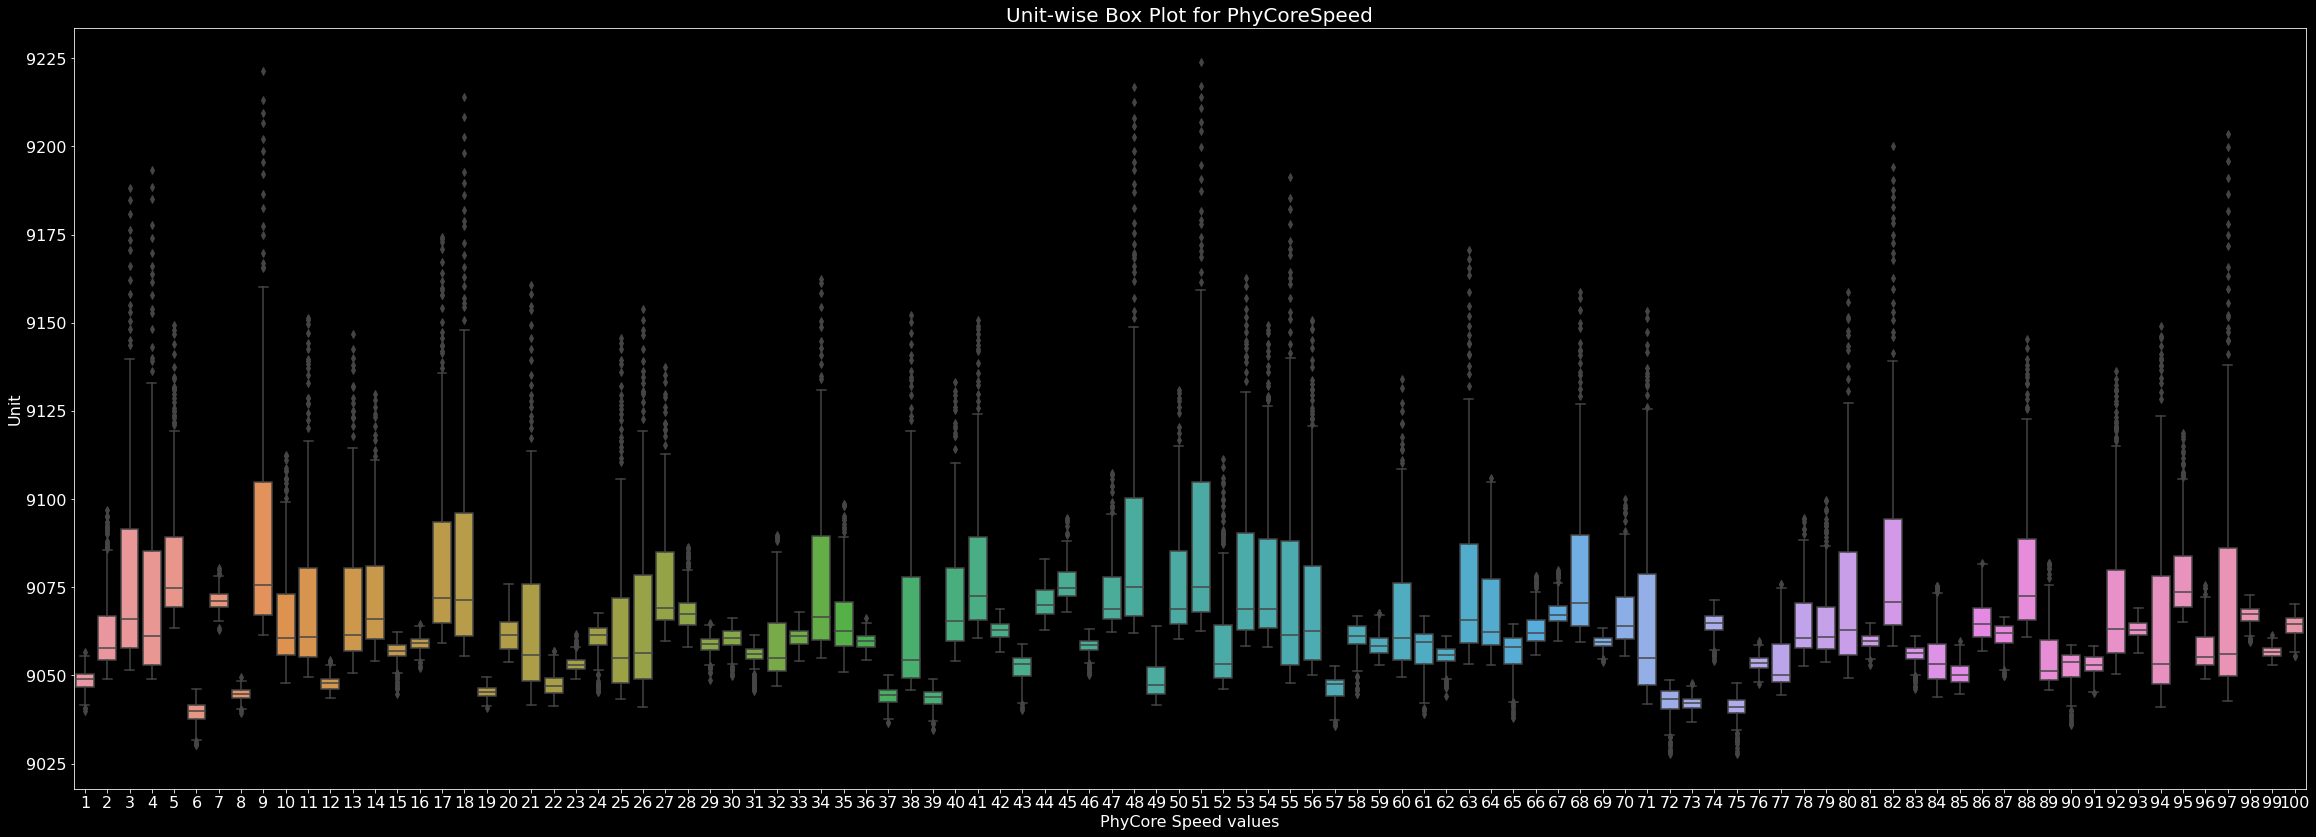

In [161]:

#df_PhysCoreSpeed = df[['Unit','PhysCoreSpeed']]
fig, ax = plt.subplots(figsize=(40, 14))
 
# Using Seaborn Library for Box Plot
ax= sns.boxplot(x=df['Unit'],
            y=df['PhysCoreSpeed'])
 
# Defining the title and axes names
ax.set_title('Unit-wise Box Plot for PhyCoreSpeed',
                fontsize=20, loc='center')
ax.set_xlabel('PhyCore Speed values')
ax.set_ylabel("Unit")
 
#fig.autofmt_xdate()
fig.show()
#Here, we can see 2 columns have very high values, bcoz of that plots is not much clear.So, eliminating those 2 columns


#### Visulaizing all sensors of all engine units through box plot

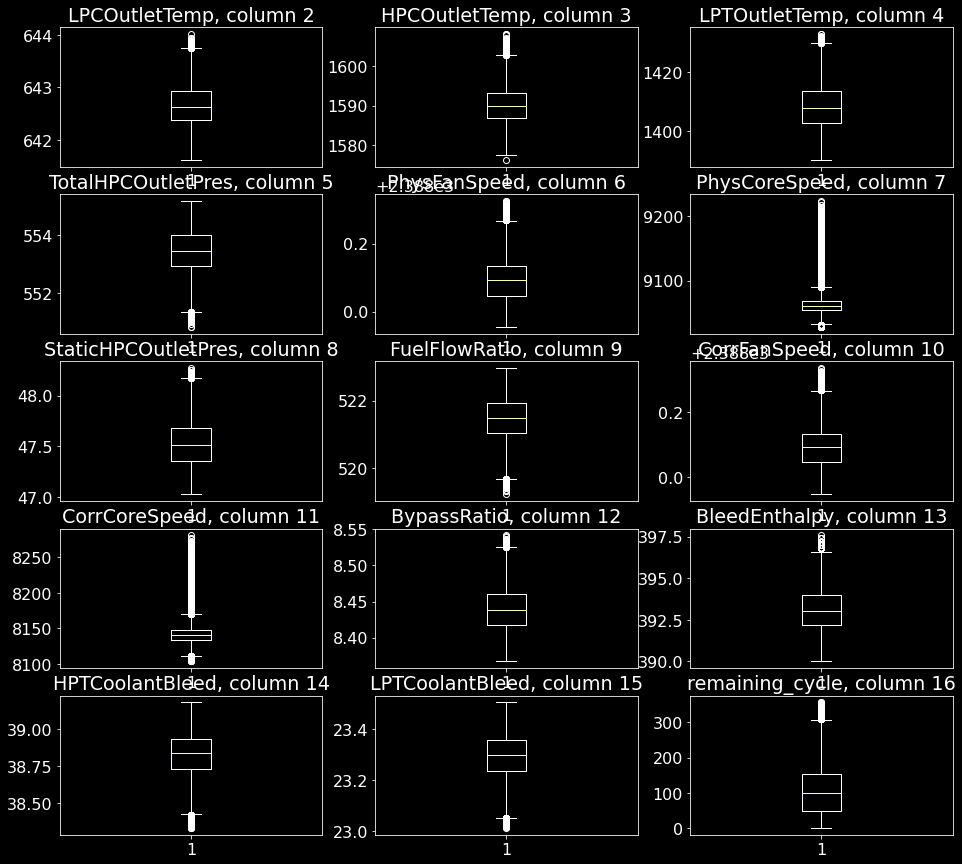

In [179]:
plt.figure(figsize = (16, 21))

for i,j in enumerate(df.columns[2:-1]):
    #temp_data = df.iloc[:,i+2]
    plt.subplot(7,3,i+1)
    plt.boxplot(df[j])
    plt.title(j + ", column "+ str(i+2))
plt.show()

In [173]:
df

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle,label
0,2,5,641.734,1584.478,1396.394,554.762,2388.008,9055.286,47.148,522.474,2387.980,8137.300,8.39518,391.0,39.084,23.44362,282,0
1,2,6,641.616,1583.210,1397.490,554.852,2388.014,9055.156,47.172,522.568,2387.966,8136.486,8.39308,391.2,39.126,23.43732,281,0
2,2,7,641.658,1583.298,1398.994,554.866,2388.028,9055.428,47.144,522.456,2387.978,8137.534,8.38856,391.0,39.134,23.44998,280,0
3,2,8,641.858,1583.716,1398.280,554.768,2388.022,9055.744,47.140,522.494,2387.972,8137.002,8.38974,391.0,39.134,23.45260,279,0
4,2,9,641.918,1583.284,1398.066,554.856,2388.030,9054.476,47.148,522.476,2387.982,8137.972,8.38674,390.8,39.120,23.44956,278,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,71,204,643.412,1600.718,1430.276,551.716,2388.128,9141.576,48.020,520.408,2388.142,8210.328,8.51390,396.6,38.526,23.03768,4,1
20227,71,205,643.552,1602.200,1428.934,551.774,2388.128,9143.782,48.036,520.464,2388.152,8212.210,8.51514,396.6,38.528,23.06698,3,1
20228,71,206,643.568,1601.592,1429.728,551.776,2388.138,9147.260,48.068,520.464,2388.152,8213.376,8.52370,396.4,38.516,23.08974,2,1
20229,71,207,643.560,1600.980,1430.362,551.678,2388.140,9151.368,48.140,520.448,2388.158,8214.558,8.52834,396.4,38.506,23.10416,1,1


### Calculating RUL (from cycle time of each unit)

In [609]:
rul = pd.DataFrame(df.groupby('Unit')['Time'].max()).reset_index()
rul.columns = ['Unit', 'RUL']
rul

,Unit,RUL
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [610]:
#Merging the RUL column 
#Later, calculating remaining cycle time from RUL 

df=df.merge(rul,on=['Unit'],how='left')
if "RUL_x" in df.columns:
    df.drop(["RUL_x","RUL_y"],axis=1,inplace=True)
#print(df)
df["remaining_cycle"]=df["RUL"]- df["Time"]
if "RUL" in df.columns:
    df.drop(["RUL"],axis=1,inplace=True)
#df.head()

In [611]:
df

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle
0,2,5,641.734,1584.478,1396.394,554.762,2388.008,9055.286,47.148,522.474,2387.980,8137.300,8.39518,391.0,39.084,23.44362,282
1,2,6,641.616,1583.210,1397.490,554.852,2388.014,9055.156,47.172,522.568,2387.966,8136.486,8.39308,391.2,39.126,23.43732,281
2,2,7,641.658,1583.298,1398.994,554.866,2388.028,9055.428,47.144,522.456,2387.978,8137.534,8.38856,391.0,39.134,23.44998,280
3,2,8,641.858,1583.716,1398.280,554.768,2388.022,9055.744,47.140,522.494,2387.972,8137.002,8.38974,391.0,39.134,23.45260,279
4,2,9,641.918,1583.284,1398.066,554.856,2388.030,9054.476,47.148,522.476,2387.982,8137.972,8.38674,390.8,39.120,23.44956,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,71,204,643.412,1600.718,1430.276,551.716,2388.128,9141.576,48.020,520.408,2388.142,8210.328,8.51390,396.6,38.526,23.03768,4
20227,71,205,643.552,1602.200,1428.934,551.774,2388.128,9143.782,48.036,520.464,2388.152,8212.210,8.51514,396.6,38.528,23.06698,3
20228,71,206,643.568,1601.592,1429.728,551.776,2388.138,9147.260,48.068,520.464,2388.152,8213.376,8.52370,396.4,38.516,23.08974,2
20229,71,207,643.560,1600.980,1430.362,551.678,2388.140,9151.368,48.140,520.448,2388.158,8214.558,8.52834,396.4,38.506,23.10416,1


#### Visualizing each sensor for each unit (Line Plot)

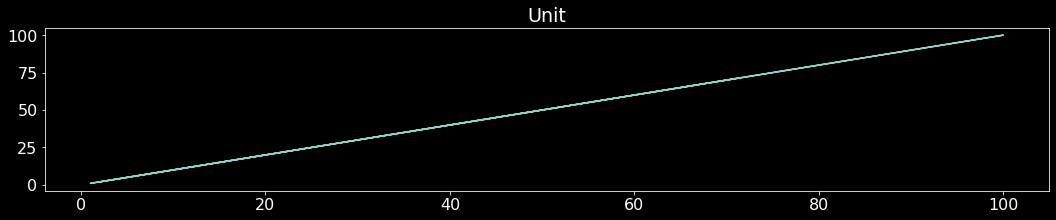

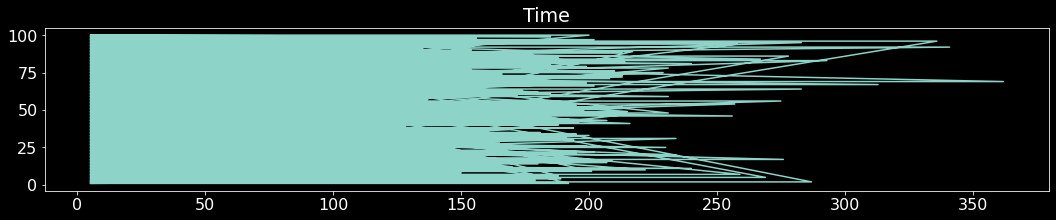

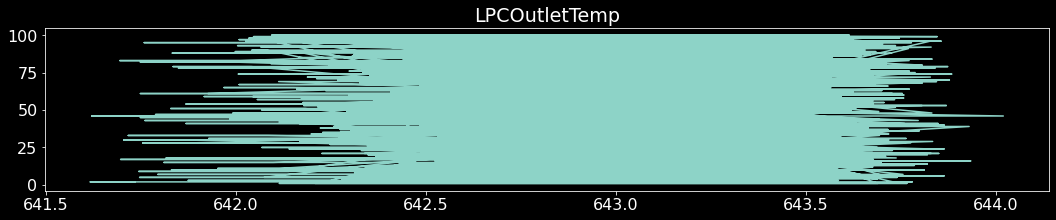

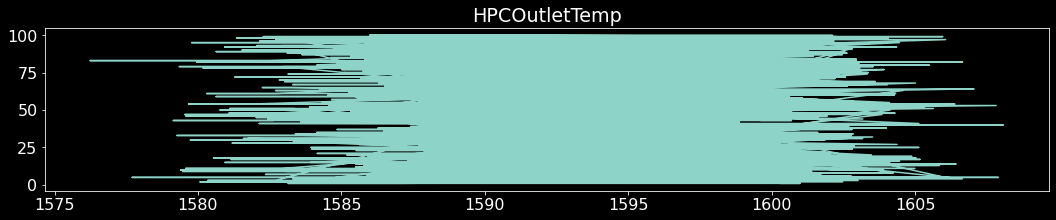

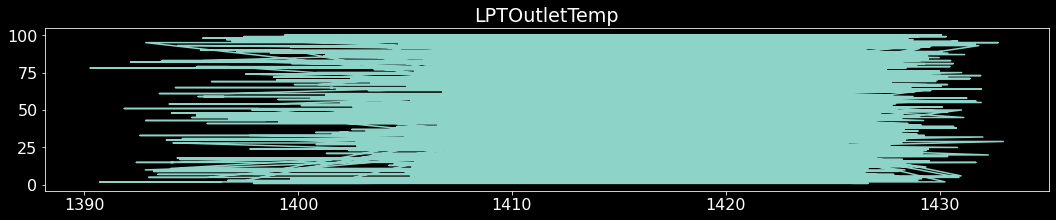

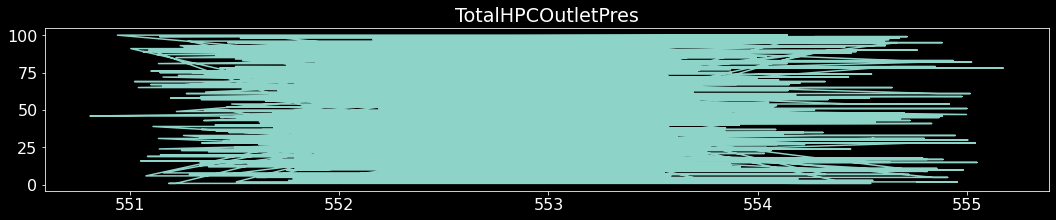

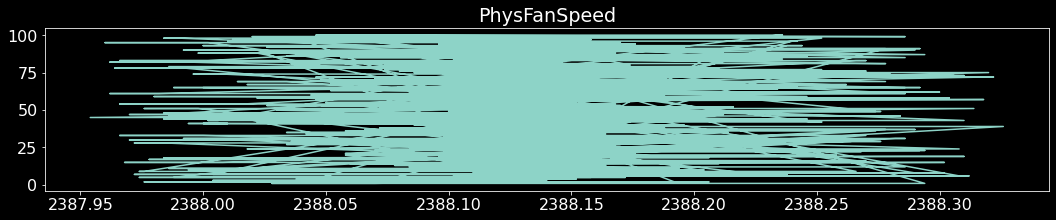

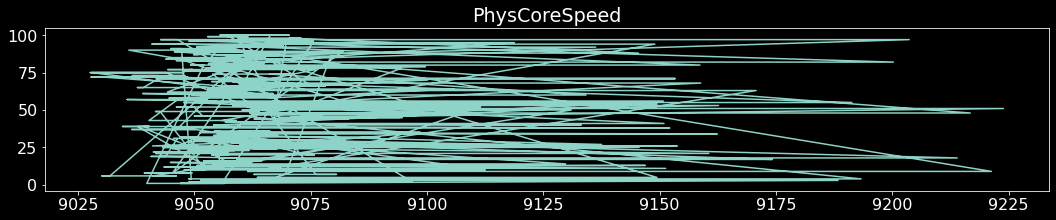

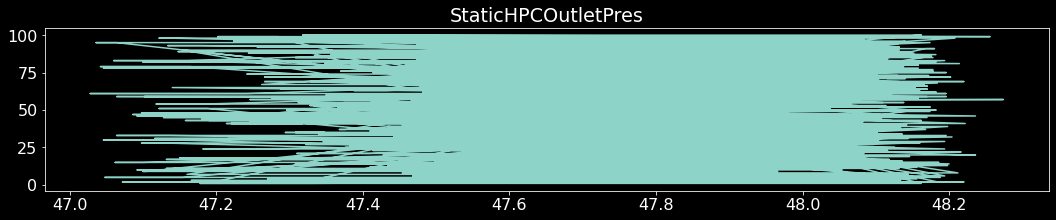

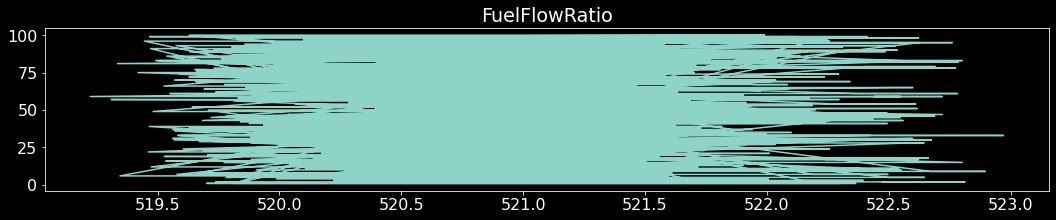

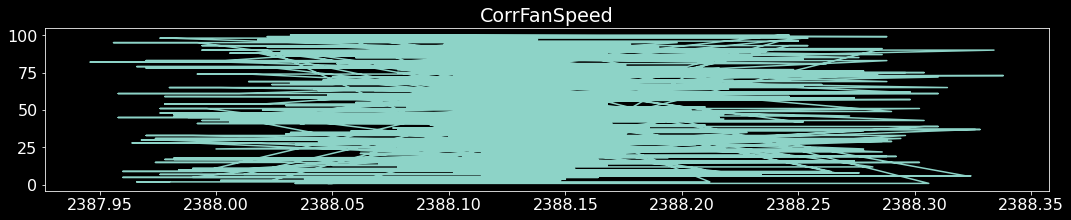

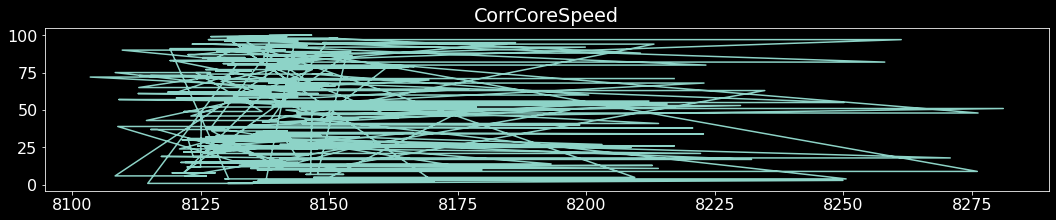

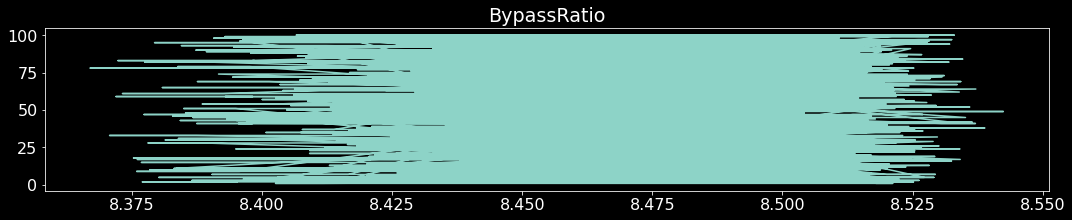

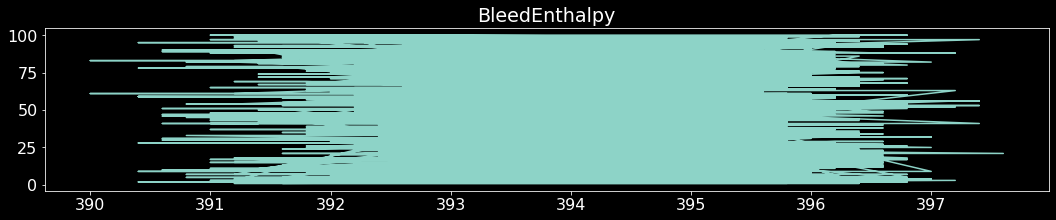

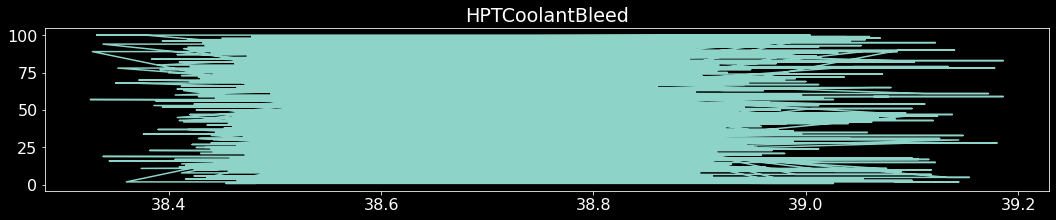

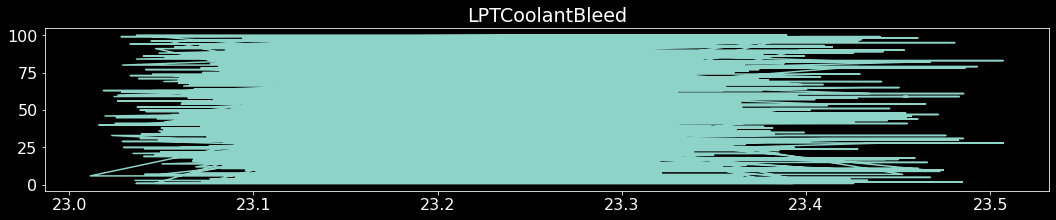

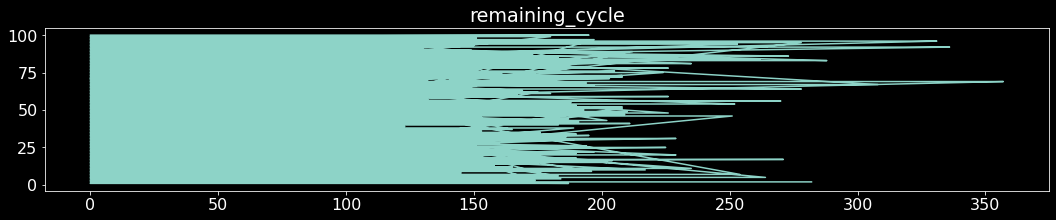

In [197]:
# Extract the readings from the dataset
names=df.columns

# Plot time series for each sensor 
for name in names:
    _ = plt.figure(figsize=(18,3))
    #_ = plt.plot(df[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[name], df['Unit'])
    _ = plt.title(name)
    plt.show()

### Correlation

In [612]:
cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr = df.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle
Unit,1.00,0.08,0.02,0.02,0.03,-0.04,0.05,-0.05,0.03,-0.04,0.05,-0.06,0.03,0.02,-0.03,-0.02,0.08
Time,0.08,1.00,0.65,0.66,0.68,-0.65,0.51,0.45,0.67,-0.65,0.51,0.37,0.66,0.67,-0.67,-0.67,-0.73
LPCOutletTemp,0.02,0.65,1.00,0.88,0.92,-0.91,0.84,0.31,0.93,-0.92,0.84,0.20,0.91,0.89,-0.90,-0.91,-0.71
HPCOutletTemp,0.02,0.66,0.88,1.00,0.90,-0.89,0.80,0.39,0.91,-0.89,0.79,0.28,0.89,0.88,-0.89,-0.89,-0.71
LPTOutletTemp,0.03,0.68,0.92,0.90,1.00,-0.94,0.88,0.31,0.96,-0.95,0.87,0.19,0.94,0.91,-0.93,-0.93,-0.73
TotalHPCOutletPres,-0.04,-0.65,-0.91,-0.89,-0.94,1.00,-0.90,-0.23,-0.96,0.95,-0.90,-0.11,-0.93,-0.90,0.92,0.92,0.71
PhysFanSpeed,0.05,0.51,0.84,0.80,0.88,-0.90,1.00,-0.06,0.90,-0.91,0.96,-0.19,0.86,0.80,-0.85,-0.85,-0.60
PhysCoreSpeed,-0.05,0.45,0.31,0.39,0.31,-0.23,-0.06,1.00,0.28,-0.21,-0.06,0.99,0.33,0.39,-0.32,-0.33,-0.39
StaticHPCOutletPres,0.03,0.67,0.93,0.91,0.96,-0.96,0.90,0.28,1.00,-0.96,0.89,0.16,0.94,0.92,-0.94,-0.94,-0.73
FuelFlowRatio,-0.04,-0.65,-0.92,-0.89,-0.95,0.95,-0.91,-0.21,-0.96,1.00,-0.91,-0.09,-0.93,-0.90,0.93,0.93,0.72


From the above correlation plot, it is clearly visible that features 

    i. PhysFanSpeed highly correlated with CorrFanSpeed
    ii. PhysCoreSpeed highly correlated with CorrCoreSpeed
    iii. StaticHPCOutletPres highly correlated with TotalHPCOutletPres
    iv. FuelFlowRatio is highly correlated LPTOutletTemp

So removing CorrFanSpeed,CorrCoreSpeed,StaticHPCOutletPres,FuelFlowRatio features (due to high VIF)

In [629]:
#Now, agin plotting the correlation with the selected features

cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr1 = df.drop(['CorrFanSpeed','CorrCoreSpeed','StaticHPCOutletPres','FuelFlowRatio'],axis=1).corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle
Unit,1.00,0.08,0.02,0.02,0.03,-0.04,0.05,-0.05,0.03,0.02,-0.03,-0.02,0.08
Time,0.08,1.00,0.65,0.66,0.68,-0.65,0.51,0.45,0.66,0.67,-0.67,-0.67,-0.73
LPCOutletTemp,0.02,0.65,1.00,0.88,0.92,-0.91,0.84,0.31,0.91,0.89,-0.90,-0.91,-0.71
HPCOutletTemp,0.02,0.66,0.88,1.00,0.90,-0.89,0.80,0.39,0.89,0.88,-0.89,-0.89,-0.71
LPTOutletTemp,0.03,0.68,0.92,0.90,1.00,-0.94,0.88,0.31,0.94,0.91,-0.93,-0.93,-0.73
TotalHPCOutletPres,-0.04,-0.65,-0.91,-0.89,-0.94,1.00,-0.90,-0.23,-0.93,-0.90,0.92,0.92,0.71
PhysFanSpeed,0.05,0.51,0.84,0.80,0.88,-0.90,1.00,-0.06,0.86,0.80,-0.85,-0.85,-0.60
PhysCoreSpeed,-0.05,0.45,0.31,0.39,0.31,-0.23,-0.06,1.00,0.33,0.39,-0.32,-0.33,-0.39
BypassRatio,0.03,0.66,0.91,0.89,0.94,-0.93,0.86,0.33,1.00,0.90,-0.92,-0.92,-0.73
BleedEnthalpy,0.02,0.67,0.89,0.88,0.91,-0.90,0.80,0.39,0.90,1.00,-0.90,-0.90,-0.72


In [632]:
threshold = 0.95

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = corr1.columns[columns]
selected_columns

df1 = df[selected_columns]
df1.head()

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle
0,2,5,641.734,1584.478,1396.394,554.762,2388.008,9055.286,8.39518,391.0,39.084,23.44362,282
1,2,6,641.616,1583.210,1397.490,554.852,2388.014,9055.156,8.39308,391.2,39.126,23.43732,281
2,2,7,641.658,1583.298,1398.994,554.866,2388.028,9055.428,8.38856,391.0,39.134,23.44998,280
3,2,8,641.858,1583.716,1398.280,554.768,2388.022,9055.744,8.38974,391.0,39.134,23.45260,279
4,2,9,641.918,1583.284,1398.066,554.856,2388.030,9054.476,8.38674,390.8,39.120,23.44956,278


In [633]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('Highly correlated columns are', to_drop)

# drop the columns
df1=df.drop(to_drop, axis=1)

#After dropping highly correlated features,
df1


Highly correlated columns are ['StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed']


<ipython-input-633-e7ffcccc4a4c>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle
0,2,5,641.734,1584.478,1396.394,554.762,2388.008,9055.286,8.39518,391.0,39.084,23.44362,282
1,2,6,641.616,1583.210,1397.490,554.852,2388.014,9055.156,8.39308,391.2,39.126,23.43732,281
2,2,7,641.658,1583.298,1398.994,554.866,2388.028,9055.428,8.38856,391.0,39.134,23.44998,280
3,2,8,641.858,1583.716,1398.280,554.768,2388.022,9055.744,8.38974,391.0,39.134,23.45260,279
4,2,9,641.918,1583.284,1398.066,554.856,2388.030,9054.476,8.38674,390.8,39.120,23.44956,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,71,204,643.412,1600.718,1430.276,551.716,2388.128,9141.576,8.51390,396.6,38.526,23.03768,4
20227,71,205,643.552,1602.200,1428.934,551.774,2388.128,9143.782,8.51514,396.6,38.528,23.06698,3
20228,71,206,643.568,1601.592,1429.728,551.776,2388.138,9147.260,8.52370,396.4,38.516,23.08974,2
20229,71,207,643.560,1600.980,1430.362,551.678,2388.140,9151.368,8.52834,396.4,38.506,23.10416,1


### Multi Collinearity Check

In [518]:
#One way of checking multi collinearity is using VIF method.
# VIF
def calc_vif(X):
    '''
        returns VIF value of features in dataframe
        Args:
            Input refers to dataframe input
    '''

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [634]:

#Checking VIF of (post removing high correlation) features
df2=corr1.copy()
vif = corr.iloc[:,:-1]
calc_vif(vif)


,variables,VIF
0,Unit,1.091345
1,Time,30.634436
2,LPCOutletTemp,711.783019
3,HPCOutletTemp,474.420325
4,LPTOutletTemp,2871.904674
5,TotalHPCOutletPres,2408.123610
6,PhysFanSpeed,2305.429952
7,PhysCoreSpeed,125.539919
8,BypassRatio,1429.037885
9,BleedEnthalpy,638.189767


When we check multi collinearity, we can see almost all independent variables have very high VIF value.

we are more interested in making our model predictions, then we might not worry about multicollinearity.

If our focus towards model inference, then we need to fix this either by removing high VIF variables or standardizing(subtracting from mean) or PCA technique.

### PCA

Explained variation per principal component:
if n_components= 0,   variance=71.000000
if n_components= 1,   variance=85.000000
if n_components= 2,   variance=91.000000
if n_components= 3,   variance=94.000000
if n_components= 4,   variance=95.000000
if n_components= 5,   variance=96.000000
if n_components= 6,   variance=97.000000
if n_components= 7,   variance=97.000000
if n_components= 8,   variance=98.000000
if n_components= 9,   variance=98.000000
if n_components= 10,   variance=99.000000
if n_components= 11,   variance=99.000000
if n_components= 12,   variance=99.000000
if n_components= 13,   variance=100.000000
if n_components= 14,   variance=100.000000
if n_components= 15,   variance=100.000000
if n_components= 16,   variance=100.000000


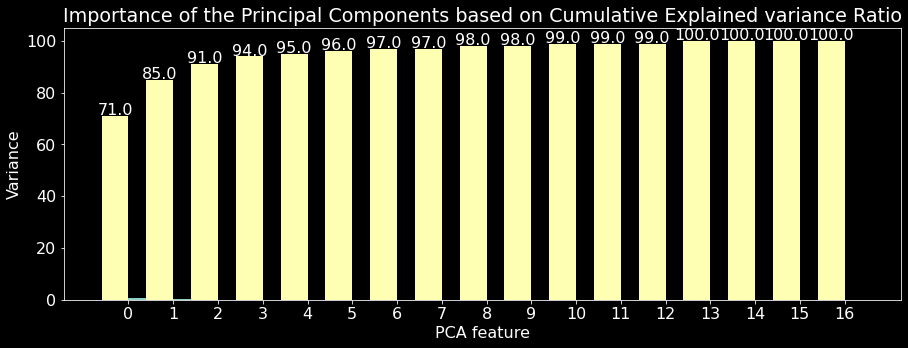

In [636]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
#df2 = df.drop(['machine_status'], axis=1)
names=df.columns
x = df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

print('Explained variation per principal component:')
exp_var_cumsum=pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),2)*100)  

for index,var in enumerate(exp_var_cumsum):  
    print('if n_components= %d,   variance=%f' %(index,var))

#So, it taked 18 componenet to obtain 100% information of original dataset.

# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_ratio_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on Cumulative Explained variance Ratio")

#for i, v in enumerate(exp_var_cumsum):
#   _ = plt.text( i, v, str(v), color='white', fontweight='bold')
xx = np.arange(len(features))
width = 0.6
pps = plt.bar(xx - width / 2,exp_var_cumsum, width, label='Cumulative Explained variance Ratio')
for p in pps:
    height = p.get_height()
    plt.text(x=p.get_x() + p.get_width() / 2, y=height+.45, s="{}".format(height),ha='center')
plt.show()


In general, to determine the no. of PCA components , it should be minimum of 65% cumulative explained variance ratio value.

From the above plot, we can determine 2 PCA components would be sufficient for our case (85% - PCA 1 and PCA 2 combined) as it is above threshold

In [637]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [652]:
principalDf['remaining_cycle']=df['remaining_cycle']
principalDf

,pc1,pc2,remaining_cycle
0,199.445065,26.894205,282
1,198.106051,26.822374,281
2,196.491095,26.855590,280
3,195.132767,26.837451,279
4,193.836182,26.812172,278
...,...,...,...
20226,-152.074119,8.021672,4
20227,-153.841039,8.237154,3
20228,-155.752720,8.467819,2
20229,-157.728983,8.735644,1


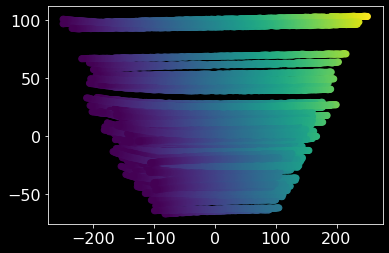

In [653]:
plt.scatter(principalDf['pc1'],principalDf['pc2'],c=principalDf['remaining_cycle'])
#plt.scatter(principalDf['pc2'],principalDf['pc2'],c='b')

plt.show()


In [655]:
ax1= fig.add_subplot(projection='3d')
ax1.scatter(principalDf['pc1'],principalDf['pc2'],c=principalDf['remaining_cycle'])
plt.show()

Here, we will train the models in two different scenarios  i.e.

    i. using raw dataset (remove highly correlated features) and 
    ii. reducing dimensionality reduction (PCA) 

## RUL Prediction

### Train and Test Split

i. using raw dataset

In [656]:
y=df1.iloc[:,-1]
x=df1.iloc[:,:-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=11)
# gc.collect()  
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16184, 12)
X_test shape :  (4047, 12)
y_train shape :  (16184,)
y_test shape :  (4047,)


Distribution on Train and Test set on each sensors

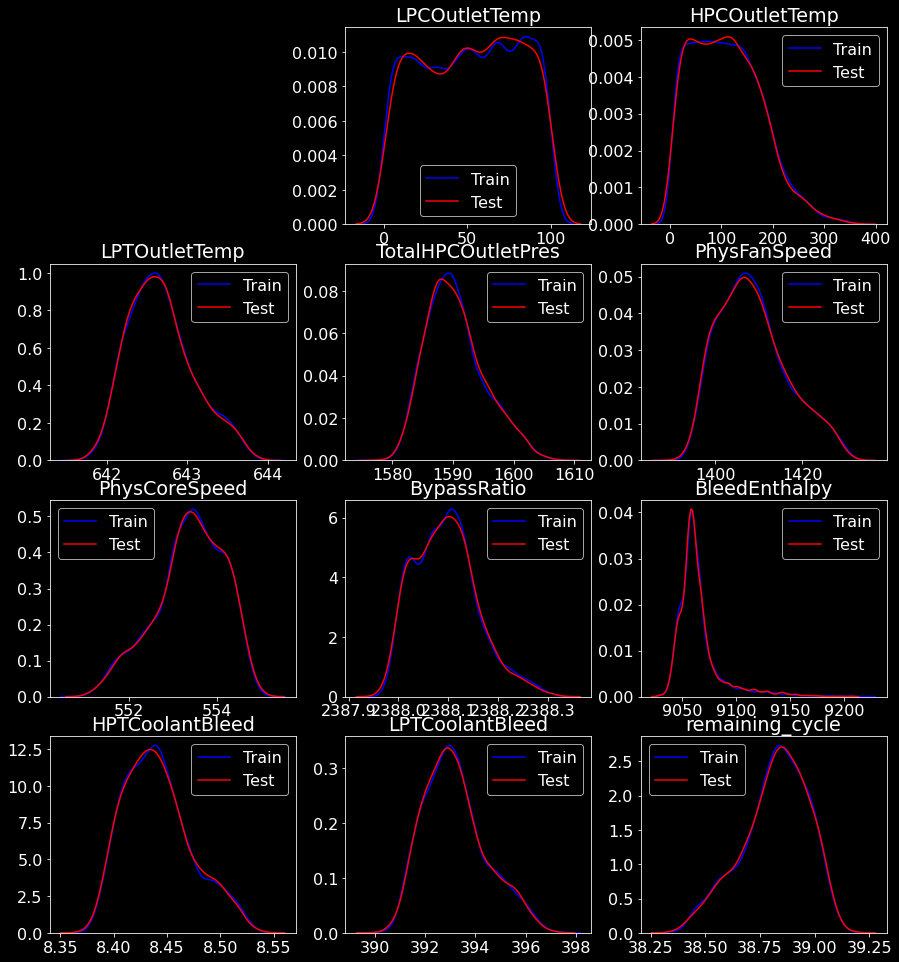

In [669]:
plt.figure(figsize = (15, 21))
for i,j in enumerate(df1.columns[2:]):
    temp_train = X_train.iloc[:, i]
    temp_test = X_test.iloc[:, i]
    plt.subplot(5,3,i+2)
    sns.kdeplot(temp_train, legend = False, color = "blue", label = "Train")
    sns.kdeplot(temp_test, legend = False, color = "red", label = "Test")
    plt.title(j)
    plt.legend()
plt.show()

ii. Using PCA features

In [657]:
pcy=principalDf.iloc[:,-1]
pcx=principalDf.iloc[:,:2]
from sklearn.model_selection import train_test_split
pcX_train, pcX_test, pcy_train, pcy_test=train_test_split(pcx,pcy, test_size=0.2, random_state=11)
# gc.collect()  
print('X_train shape : ',pcX_train.shape)
print('X_test shape : ',pcX_test.shape)
print('y_train shape : ',pcy_train.shape)
print('y_test shape : ',pcy_test.shape)

X_train shape :  (16184, 2)
X_test shape :  (4047, 2)
y_train shape :  (16184,)
y_test shape :  (4047,)


Distribution on Train and Test set (PCA) on each sensors

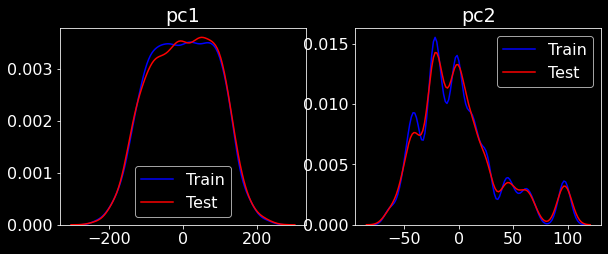

In [674]:
plt.figure(figsize = (15, 21))
for i,j in enumerate(principalDf.columns[:2]):
    temp_train = pcX_train.iloc[:, i]
    temp_test = pcX_test.iloc[:, i]
    plt.subplot(5,3,i+2)
    sns.kdeplot(temp_train, legend = False, color = "blue", label = "Train")
    sns.kdeplot(temp_test, legend = False, color = "red", label = "Test")
    plt.title(j)
    plt.legend()
plt.show()

### Model Building

In [663]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
   
    print('###########  {} set ##############'.format(label))
    print('RMSE: {} '.format(rmse))
    print( 'R2: {}' .format(variance))

#### Linear Regression (Using Scikit Learn)

In [666]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'training')
print('\n')
y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

###########  training set ##############
RMSE: 39.11601069778081 
R2: 0.666837647095934


###########  test set ##############
RMSE: 39.54431885615037 
R2: 0.6657252056906058


In [668]:
# create and fit model using pca features
pclm = LinearRegression()
pclm.fit(pcX_train, pcy_train)

# predict and evaluate
pcy_hat_train = pclm.predict(pcX_train)
evaluate(pcy_train, pcy_hat_train, 'train')

print('\n')
pcy_hat_test = pclm.predict(pcX_test)
evaluate(pcy_test, pcy_hat_test)

###########  train set ##############
RMSE: 8.017995922732524 
R2: 0.9860015977099795


###########  test set ##############
RMSE: 7.879467615159387 
R2: 0.9867282197718553


Cross Validation

In [786]:
# evaluate model usingraw sensor data
scores = cross_val_score(lm, x, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean RMSE: 1538.494 (59.684)


In [787]:
# evaluate model using pca features
scores = cross_val_score(pclm, pcx, pcy, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean RMSE: 63.866 (1.678)


#### Linear Regression (Using Statsmodels)

In [723]:
# using raw dataset
lm1 = sm.OLS(y_train,sm.add_constant(X_train))
results= lm1.fit()
print(results.summary())

# predict and evaluate
y_hat_train = results.predict(sm.add_constant(X_train))
evaluate(y_train, y_hat_train, 'training')
print('\n')
y_hat_test = results.predict(sm.add_constant(X_test))
evaluate(y_test, y_hat_test)


                            OLS Regression Results                            
Dep. Variable:        remaining_cycle   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2697.
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:35:34   Log-Likelihood:                -82303.
No. Observations:               16184   AIC:                         1.646e+05
Df Residuals:                   16171   BIC:                         1.647e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.337e+04    4.5

In [725]:
# create and fit model using pca features
pclm1 = sm.OLS(pcy_train,sm.add_constant(pcX_train))
results1 = pclm1.fit()

print(results1.summary())

# predict and evaluate

# predict and evaluate
pcy_hat_train = results1.predict(sm.add_constant(pcX_train))
evaluate(pcy_train, pcy_hat_train, 'train')

print('\n')
pcy_hat_test = results1.predict(sm.add_constant(pcX_test))
evaluate(pcy_test, pcy_hat_test)


                            OLS Regression Results                            
Dep. Variable:        remaining_cycle   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 5.699e+05
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:36:59   Log-Likelihood:                -56654.
No. Observations:               16184   AIC:                         1.133e+05
Df Residuals:                   16181   BIC:                         1.133e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.9117      0.063   1680.241      0.0

Feature Importance

P-Value of all features in the dataset 

P-value for feature :  Unit --> 0.6032345819136812
P-value for feature :  Time --> 5.392203693643616e-148
P-value for feature :  LPCOutletTemp --> 0.0
P-value for feature :  HPCOutletTemp --> 5.865887272910635e-08
P-value for feature :  LPTOutletTemp --> 0.0024017198861071335
P-value for feature :  TotalHPCOutletPres --> 1.2303959250605465e-08
P-value for feature :  PhysFanSpeed --> 4.136748812706637e-07
P-value for feature :  PhysCoreSpeed --> 0.4948408106608234
P-value for feature :  BypassRatio --> 6.531927650580528e-10
P-value for feature :  BleedEnthalpy --> 1.2620021568058076e-06
P-value for feature :  HPTCoolantBleed --> 0.21427442026395324
P-value for feature :  LPTCoolantBleed --> 0.06297103877091106
P-value for feature :  remaining_cycle --> 2.2560841747132096e-06

 Most Significant features (p<0.05):
              feature        p-value
0       LPCOutletTemp   0.000000e+00
1                Time  5.392204e-148
2         BypassRatio   6

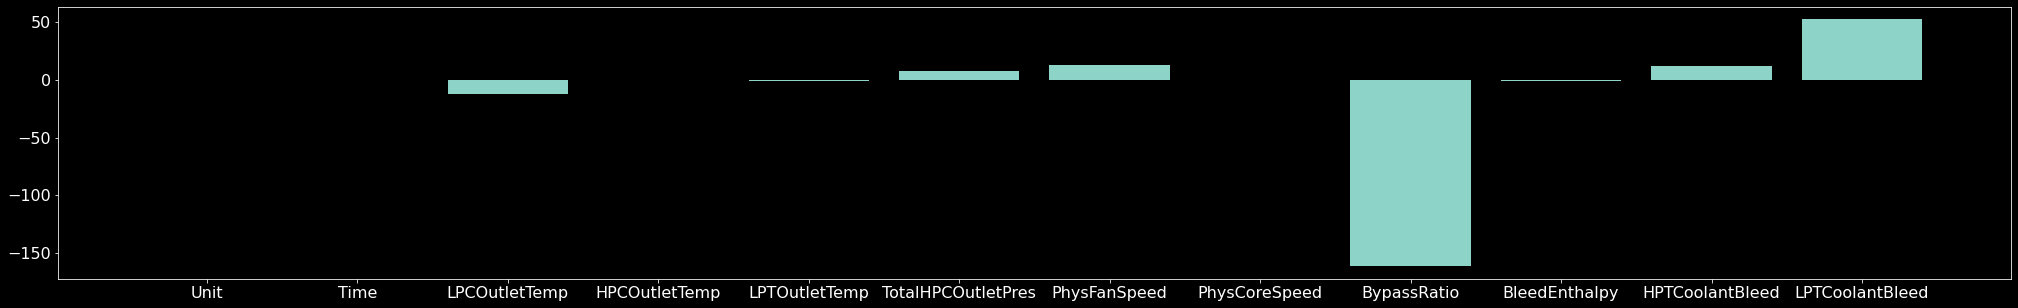

In [730]:
print('P-Value of all features in the dataset \n')
for attributeIndex in range (0, 13):
    #get pvalues of each feature
    print('P-value for feature : ', df1.columns[attributeIndex],'-->',results.pvalues[attributeIndex])

#print('\n P-Value of features that are only significant \n')
important_features_dict = {}
for attributeIndex in range (0, 13):
    #get pvalues of each feature
    if(results.pvalues[attributeIndex]<0.05):
        important_features_dict[df1.columns[attributeIndex]]=results.pvalues[attributeIndex]
        #print('P-value for feature : ', df1.columns[attributeIndex],'-->',results.pvalues[attributeIndex])
sorted_important_features_dict={k: v for k, v in sorted(important_features_dict.items(), key=lambda item: item[1])}
sorted_important_features_df=pd.DataFrame(sorted_important_features_dict.items(),columns=['feature','p-value'])

important_features_list = sorted(important_features_dict,key=important_features_dict.get,reverse=True)
#print(f'Most Significant features: {sorted_important_features_dict}')
print('\n Most Significant features (p<0.05):')
print(sorted_important_features_df)

#Also, lets see the coefficients of each features
# get coefficients
importance = lm.coef_
# summarize feature importance
print('\n Coefficients of each feature in dataset')
for i,v in enumerate(importance):
	print('Feature: %s --> Score: %.5f' % (df1.columns[i],v))
# plot feature importance
print('\n Coefficient Plot')
plt.figure(figsize=(35,5))
plt.bar([df1.columns[i] for i in range(len(importance))], importance)
plt.show()


P-Value of all features in the dataset 

P-value for feature :  pc1 --> 0.0
P-value for feature :  pc2 --> 0.0
P-value for feature :  remaining_cycle --> 0.0

 Most Significant features (p<0.05):
           feature  p-value
0              pc1      0.0
1              pc2      0.0
2  remaining_cycle      0.0

 Coefficients of each feature in dataset
Feature: pc1 --> Score: 105.912
Feature: pc2 --> Score: 0.697
Feature: remaining_cycle --> Score: 0.653

 Coefficient Plot


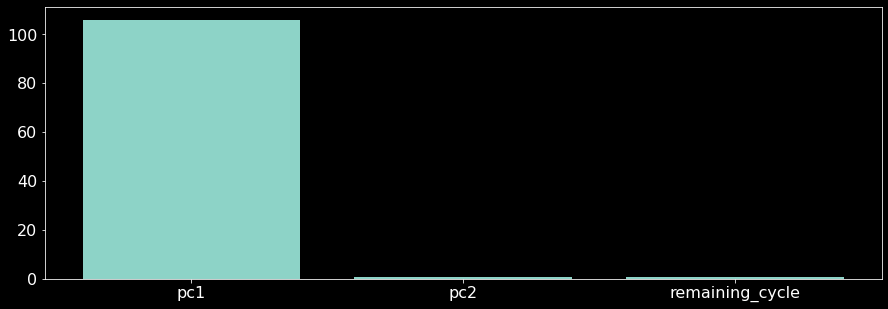

In [753]:
print('P-Value of all features in the dataset \n')
for attributeIndex in range (0, 3):
    #get pvalues of each feature
    print('P-value for feature : ', principalDf.columns[attributeIndex],'-->',results1.pvalues[attributeIndex])

#print('\n P-Value of features that are only significant \n')
important_features_dict = {}
for attributeIndex in range (0, 3):
    #get pvalues of each feature
    if(results1.pvalues[attributeIndex]<0.05):
        important_features_dict[principalDf.columns[attributeIndex]]=results1.pvalues[attributeIndex]
        #print('P-value for feature : ', df1.columns[attributeIndex],'-->',results.pvalues[attributeIndex])
sorted_important_features_dict={k: v for k, v in sorted(important_features_dict.items(), key=lambda item: item[1])}
sorted_important_features_df=pd.DataFrame(sorted_important_features_dict.items(),columns=['feature','p-value'])

important_features_list = sorted(important_features_dict,key=important_features_dict.get,reverse=True)
#print(f'Most Significant features: {sorted_important_features_dict}')
print('\n Most Significant features (p<0.05):')
print(sorted_important_features_df)

#Also, lets see the coefficients of each features
# get coefficients
importance = results1.params[0:3]
# summarize feature importance
print('\n Coefficients of each feature in dataset')
a=0
for i in range(0,3):
    
	print('Feature: %s --> Score: %.3f' % (principalDf.columns[i],importance[i]))
    #a+=1

# plot feature importance
print('\n Coefficient Plot')
plt.figure(figsize=(15,5))
plt.bar([principalDf.columns[i] for i in range(0,3)], importance)
plt.show()


Cross validation

In [727]:
# cross validation

scores = cross_val_score(lm, x, y, scoring='r2')
print(f'Cross validated R-Squared score :  {scores.mean():.4f} ± {scores.std():.4f}')


Cross validated R-Squared score :  0.6363 ± 0.0726


#### Lasso Regression

In [756]:
### using raw sensor data #######

# define model
lasso_model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(lasso_model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
lasso_search = GridSearchCV(lasso_model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
lasso_results = lasso_search.fit(x, y)
# summarize
print('RMSE: %.3f' % lasso_results.best_score_)
print('Config: %s' % lasso_results.best_params_)

Mean RMSE: 39.526 (0.774)


/Users/nirmalnk/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/Users/nirmalnk/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


RMSE: -39.216
Config: {'alpha': 0.0}


/Users/nirmalnk/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15543706.075129155, tolerance: 9327.048518975831
  model = cd_fast.enet_coordinate_descent(


In [760]:
######### using PCA features ##############

# define model
pclasso_model = Lasso()
# define model evaluation method
pccv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

####### Cross Validation ########
pcscores = cross_val_score(pclasso_model, pcx, pcy, scoring='neg_root_mean_squared_error', cv=pccv, n_jobs=-1)
# force scores to be positive
pcscores = np.abs(pcscores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(pcscores), np.std(pcscores)))


####### Hyper parmaeter tuning #######
# define grid
pcgrid = dict()
pcgrid['alpha'] = np.arange(0,1,0.01)
# define search
pclasso_search = GridSearchCV(pclasso_model, pcgrid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
pclasso_results = pclasso_search.fit(pcx, pcy)
# summarize
print('RMSE: %.3f' % pclasso_results.best_score_)
print('Config: %s' % pclasso_results.best_params_)

Mean RMSE: 7.991 (0.105)
RMSE: -7.991
Config: {'alpha': 0.02}


#### Ridge Regression

In [761]:
### using raw sensor data #######

# define model
ridge_model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(ridge_model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
ridge_search = GridSearchCV(ridge_model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
ridge_results = ridge_search.fit(x, y)
# summarize
print('RMSE: %.3f' % ridge_results.best_score_)
print('Config: %s' % ridge_results.best_params_)

Mean RMSE: 39.220 (0.761)
RMSE: -39.216
Config: {'alpha': 0.09}


In [763]:
######### using PCA features ##############

# define model
pcridge_model = Ridge()
# define model evaluation method
pccv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

####### Cross Validation ########
pcscores = cross_val_score(pcridge_model, pcx, pcy, scoring='neg_root_mean_squared_error', cv=pccv, n_jobs=-1)
# force scores to be positive
pcscores = np.abs(pcscores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(pcscores), np.std(pcscores)))


####### Hyper parmaeter tuning #######
# define grid
pcgrid = dict()
pcgrid['alpha'] = np.arange(0,1,0.01)
# define search
pcridge_search = GridSearchCV(pcridge_model, pcgrid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
pcridge_results = pcridge_search.fit(pcx,pcy)
# summarize
print('RMSE: %.3f' % pcridge_results.best_score_)
print('Config: %s' % pcridge_results.best_params_)

Mean RMSE: 7.991 (0.105)
RMSE: -7.991
Config: {'alpha': 0.99}


#### RandomForest Regressor

In [764]:
# Build the model, train it and predict for the test set 
## removing unit and time features
rf_model = RandomForestRegressor(n_estimators= 300, max_features = "sqrt",
                                 n_jobs = -1, random_state = 38)
# rf_model.fit(processed_train_data.drop(columns= ['engineNumber','cycleNumber']), processed_train_targets)
rf_model.fit(X_train.drop(columns= ['Unit','Time']), y_train)

# predict and evaluate
rul_pred_train = rf_model.predict(X_train.drop(columns= ['Unit','Time']))
evaluate(y_train, rul_pred_train, 'train')

rul_pred_test = rf_model.predict(X_test.drop(columns= ['Unit','Time']))
evaluate(y_test, rul_pred_test)

###########  train set ##############
RMSE: 13.142797974263306 
R2: 0.9623883425239466
###########  test set ##############
RMSE: 35.96079041546882 
R2: 0.7235644523378149


In [806]:
# Build the model, train it and predict for the test set
rf_model = RandomForestRegressor(n_estimators= 300, max_features = "sqrt",
                                 n_jobs = -1, random_state = 38)
# rf_model.fit(processed_train_data.drop(columns= ['engineNumber','cycleNumber']), processed_train_targets)
rf_model.fit(X_train, y_train)

# predict and evaluate
rul_pred_train = rf_model.predict(X_train)
evaluate(y_train, rul_pred_train, 'train')

rul_pred_test = rf_model.predict(X_test)
evaluate(y_test, rul_pred_test)

###########  train set ##############
RMSE: 7.072730628429086 
R2: 0.9891076636452399
###########  test set ##############
RMSE: 18.997188594405035 
R2: 0.9228538779423981


In [765]:
# Build the model, train it and predict for the test set
pcrf_model = RandomForestRegressor(n_estimators= 250, max_features = "auto",
                                 n_jobs = -1, random_state = 11)
# rf_model.fit(processed_train_data.drop(columns= ['engineNumber','cycleNumber']), processed_train_targets)
pcrf_model.fit(pcX_train, y_train)

# predict and evaluate
pcrul_pred_train = pcrf_model.predict(pcX_train)
evaluate(pcy_train, pcrul_pred_train, 'train')

pcrul_pred_test = pcrf_model.predict(pcX_test)
evaluate(pcy_test, pcrul_pred_test)

###########  train set ##############
RMSE: 1.807319735901903 
R2: 0.9992887589895055
###########  test set ##############
RMSE: 4.844991184915874 
R2: 0.9949821067945905


Cross Validation

In [784]:
# evaluate model using raw sensor data
scores = cross_val_score(rf_model, x, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean RMSE: 324.762 (15.899)


In [785]:
# evaluate model using pca features
scores = cross_val_score(pcrf_model, pcx, pcy, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean RMSE: 22.379 (0.925)


Lets see the vizualization of the prediction results for one unit 

In [788]:
## adding RUL predictions with test dataset
pred_df=X_test.copy()
pred_df['RUL_true']=y_test
pred_df['RUL_prediction']=pcrul_pred_test
pred_df

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,RUL_true,RUL_prediction
1781,55,172,643.008,1596.590,1417.336,552.954,2388.080,9125.068,8.47514,394.4,38.608,23.20092,21,19.124
13091,17,159,642.554,1585.336,1399.760,553.882,2388.022,9075.988,8.42140,392.4,38.948,23.37374,117,117.204
13572,14,6,642.686,1590.430,1408.326,553.624,2388.114,9058.444,8.43960,393.2,38.930,23.29830,174,175.376
18655,66,139,642.846,1596.562,1415.498,552.912,2388.168,9064.824,8.47030,393.6,38.752,23.23570,63,62.024
15090,49,94,642.792,1593.826,1407.800,553.420,2388.134,9043.200,8.43848,392.8,38.834,23.30338,121,117.788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14033,10,130,642.496,1589.764,1405.796,553.866,2388.052,9062.118,8.42994,392.6,38.898,23.33276,92,83.948
17862,67,73,642.410,1589.520,1404.556,553.788,2388.060,9064.388,8.43224,392.6,38.922,23.29530,240,240.980
18161,73,63,642.834,1593.414,1411.946,553.078,2388.158,9040.080,8.45068,393.2,38.848,23.24764,150,154.332
13308,29,104,642.746,1593.756,1410.574,553.362,2388.116,9058.742,8.44872,393.0,38.808,23.26894,59,59.576


In [789]:
## We're going to test for one unit i.e. Unit 1
## joining the training dataset as well in order to see the plot

pred_df_unit1=pred_df[pred_df['Unit']==1]
pred_df_unit1=pred_df_unit1[['Time','RUL_prediction']]
df_unit1=df[df['Unit']==1]
print(pred_df_unit1.shape, df_unit1.shape)

#df_unit1.set_index('Unit').join(pred_df_unit1[['Unit','RUL_prediction']].set_index('Unit'), on='Unit')
xy= pd.merge(df_unit1,pred_df_unit1,on='Time',how='left')
xy

(21, 2) (188, 17)


,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle,RUL_prediction
0,1,5,642.208,1587.030,1403.206,554.164,2388.070,9049.566,47.328,522.282,2388.048,8134.194,8.41334,391.8,38.958,23.39302,187,NaN
1,1,6,642.264,1585.984,1402.760,554.226,2388.062,9050.264,47.266,522.286,2388.050,8133.040,8.41160,391.6,38.942,23.38260,186,NaN
2,1,7,642.330,1586.084,1401.686,554.344,2388.058,9053.276,47.240,522.294,2388.042,8133.206,8.40472,391.6,38.962,23.37336,185,NaN
3,1,8,642.372,1585.078,1401.040,554.262,2388.042,9050.848,47.234,522.304,2388.042,8132.774,8.40268,391.8,38.966,23.36664,184,184.632
4,1,9,642.326,1586.716,1399.626,554.110,2388.030,9050.244,47.266,522.090,2388.036,8131.146,8.40360,391.8,39.000,23.37318,183,183.104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,1,188,643.690,1599.708,1426.654,551.646,2388.268,9043.722,48.114,519.798,2388.262,8117.222,8.51538,395.8,38.468,23.03640,4,NaN
184,1,189,643.712,1597.854,1425.752,551.586,2388.274,9043.050,48.116,519.760,2388.272,8117.602,8.51638,395.8,38.478,23.05602,3,4.000
185,1,190,643.680,1597.006,1426.062,551.516,2388.274,9042.424,48.152,519.804,2388.288,8117.380,8.52116,396.4,38.474,23.05552,2,NaN
186,1,191,643.646,1598.446,1425.956,551.186,2388.288,9040.702,48.158,519.702,2388.298,8115.612,8.52010,395.8,38.470,23.07014,1,NaN


In [790]:
#meging the train dataset RUL values with test dataset RUL predictions
yz=xy.copy()
yz['RUL_prediction'].fillna(yz['remaining_cycle'],inplace=True)
yz

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle,RUL_prediction
0,1,5,642.208,1587.030,1403.206,554.164,2388.070,9049.566,47.328,522.282,2388.048,8134.194,8.41334,391.8,38.958,23.39302,187,187.000
1,1,6,642.264,1585.984,1402.760,554.226,2388.062,9050.264,47.266,522.286,2388.050,8133.040,8.41160,391.6,38.942,23.38260,186,186.000
2,1,7,642.330,1586.084,1401.686,554.344,2388.058,9053.276,47.240,522.294,2388.042,8133.206,8.40472,391.6,38.962,23.37336,185,185.000
3,1,8,642.372,1585.078,1401.040,554.262,2388.042,9050.848,47.234,522.304,2388.042,8132.774,8.40268,391.8,38.966,23.36664,184,184.632
4,1,9,642.326,1586.716,1399.626,554.110,2388.030,9050.244,47.266,522.090,2388.036,8131.146,8.40360,391.8,39.000,23.37318,183,183.104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,1,188,643.690,1599.708,1426.654,551.646,2388.268,9043.722,48.114,519.798,2388.262,8117.222,8.51538,395.8,38.468,23.03640,4,4.000
184,1,189,643.712,1597.854,1425.752,551.586,2388.274,9043.050,48.116,519.760,2388.272,8117.602,8.51638,395.8,38.478,23.05602,3,4.000
185,1,190,643.680,1597.006,1426.062,551.516,2388.274,9042.424,48.152,519.804,2388.288,8117.380,8.52116,396.4,38.474,23.05552,2,2.000
186,1,191,643.646,1598.446,1425.956,551.186,2388.288,9040.702,48.158,519.702,2388.298,8115.612,8.52010,395.8,38.470,23.07014,1,1.000


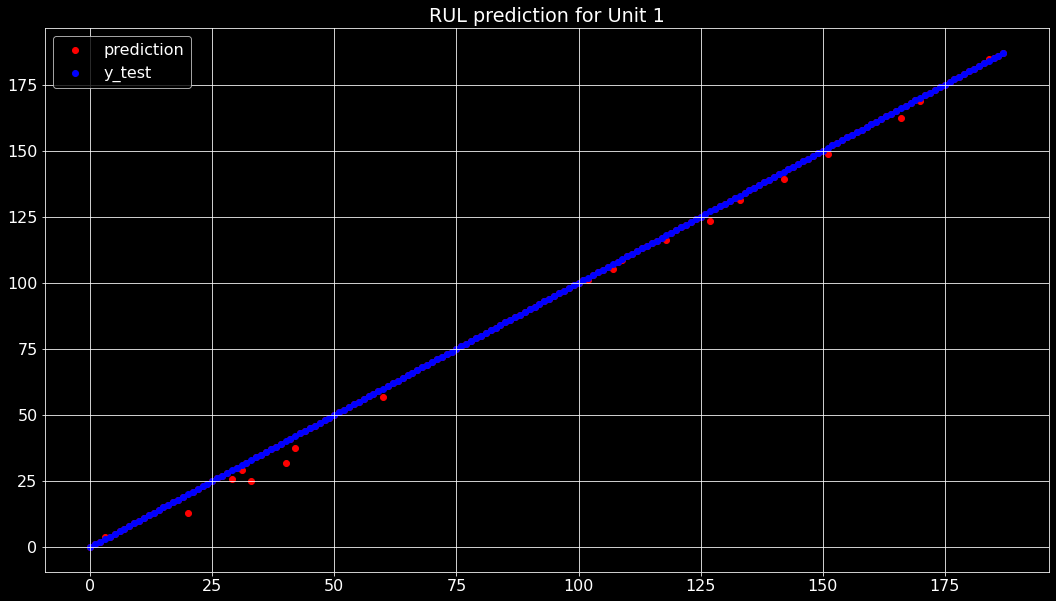

In [800]:
### visualization of prediciton results
fig = plt.figure(figsize=(18,10))
plt.scatter(yz['remaining_cycle'],yz['RUL_prediction'],color='red', label='prediction')
plt.scatter(yz['remaining_cycle'],yz['remaining_cycle'],color='blue', label='y_test')
plt.legend(loc='upper left')
plt.title('RUL prediction for Unit 1')
plt.grid()
plt.show()

Feature Importance

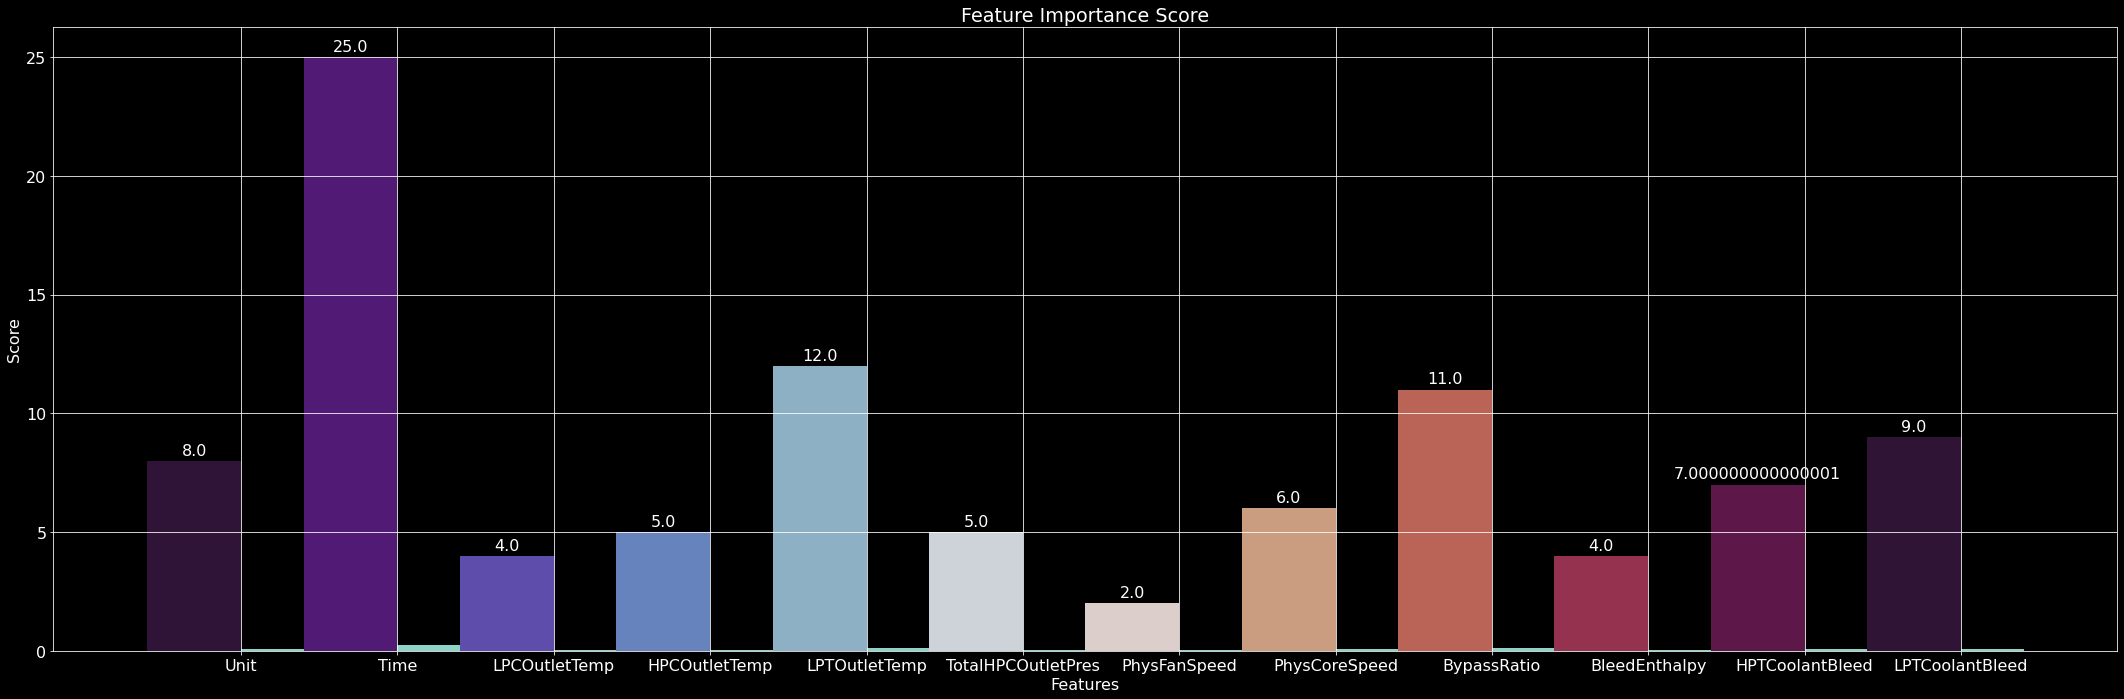

In [871]:
## Plot - feature importance

colors = [plt.cm.twilight_shifted(i/float(len(X_train.columns)-1)) for i in range(len(X_train.columns))]

features = range(len(X_train.columns))
_ = plt.figure(figsize=(30, 10))
_ = plt.bar(X_train.columns, feat_importances)
_ = plt.xlabel('Features')
_ = plt.ylabel('Score')
_ = plt.xticks(features)
_ = plt.title("Feature Importance Score")
_ = plt.tight_layout()
_ = plt.grid(True)

#plt.show()
xx = np.arange(len(features))
width = 0.6
pps = plt.bar(xx - width / 2, (np.round(feat_importances,2)*100), width, color=colors, label='Feature Importance')
for v in pps:
    #plt.text(xlocs[i] - 1.85 , v, str(np.round(v,2)*100))
    height = v.get_height()
    plt.text(x=v.get_x() + v.get_width() / 2, y=height+.25, s="{}".format(height),ha='center')
plt.show()

#### XGBoost Regressor

In [779]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.

train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
xgb_model = xgb.XGBRegressor()
xgb_r = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
xgb_pred = xgb_r.predict(test_dmatrix)
xgb_train_pred = xgb_r.predict(train_dmatrix)

# RMSE Computation
evaluate(y_train, xgb_train_pred)

# RMSE Computation
evaluate(y_test, xgb_pred)


###########  test set ##############
RMSE: 46.55970820159593 
R2: 0.5279724927020841
###########  test set ##############
RMSE: 47.07614792984416 
R2: 0.5262630393533705


In [782]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.

pctrain_dmatrix = xgb.DMatrix(data = pcX_train, label = pcy_train)
pctest_dmatrix = xgb.DMatrix(data = pcX_test, label = pcy_test)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
pcxgb_model = xgb.XGBRegressor()
pcxgb_r = xgb.train(params = param, dtrain = pctrain_dmatrix, num_boost_round = 10)
pcxgb_pred = pcxgb_r.predict(pctest_dmatrix)
pcxgb_train_pred = pcxgb_r.predict(pctrain_dmatrix)

# RMSE Computation
evaluate(pcy_train, pcxgb_train_pred)

# RMSE Computation
evaluate(pcy_test, pcxgb_pred)

###########  test set ##############
RMSE: 8.019023560146687 
R2: 0.9859980092312811
###########  test set ##############
RMSE: 7.880387060883752 
R2: 0.9867251222545763


Cross Validation

In [781]:
# evaluate model using raw sensor data
scores = cross_val_score(xgb_model, x, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean RMSE: 56.723 (5.422)


In [783]:
# evaluate model using pca features
scores = cross_val_score(pcxgb_model, pcx, pcy, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean RMSE: 27.032 (1.150)


In [99]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05), 
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))

/Users/nirmalnk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:52:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameter: 
 {'subsample': 0.8500000000000001, 'scale_pos_weight': 140, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.085, 'gamma': 0.7999999999999999, 'colsample_bytree': 0.5500000000000002}
XGBClassifier Acc Score:  1.0


### conclusion
When we do cross validation , we can see RMSE value is low for random forest regressor with PCA features as input for the model.
So, this could be most prefered model for RUL prediction.

## Anomaly Detection

### 1. IQR (Inter Quanitle Range) Approach

In [462]:
df.columns

Index(['Unit', 'Time', 'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp',
       'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed',
       'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed',
       'BypassRatio', 'BleedEnthalpy', 'HPTCoolantBleed', 'LPTCoolantBleed',
       'remaining_cycle', 'anomaly_pc1', 'anomaly_pc2'],
      dtype='object')

 0 - Inliers and 1 - Anomalies 
PhysCoreSpeed Outlier data points distribution 
 0    19495
1      736
Name: IQR_anomaly, dtype: int64


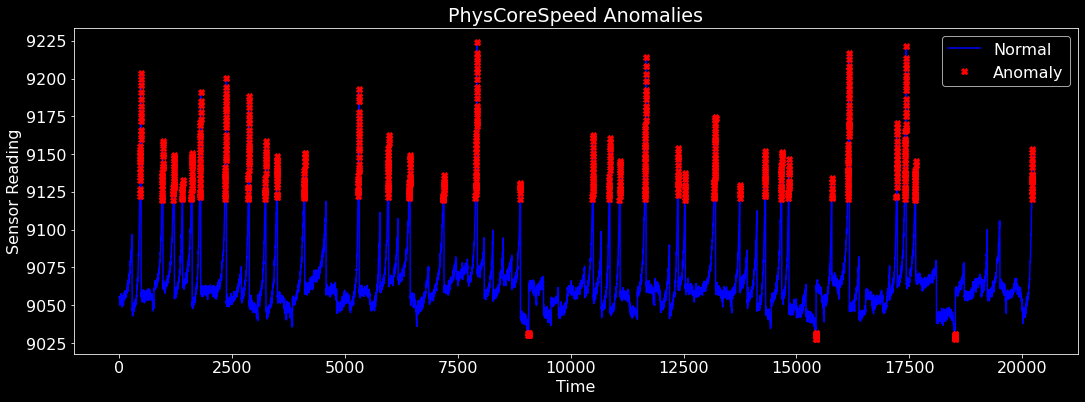

In [879]:
dfa=df1.copy()

# Calculate IQR for the PhysCoreSpeed
q1, q3 = dfa['PhysCoreSpeed'].quantile([0.25, 0.75])
iqr = q3 - q1

# Calculate upper and lower bounds for outlier for PhySCoreSpeed Sensor
lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (3.5*iqr)
# Filter out the outliers from the pc1

dfa['IQR_anomaly'] = ((dfa['PhysCoreSpeed']>upper_bound) | (dfa['PhysCoreSpeed']<lower_bound)).astype('int')

# Let's plot the outliers from pc1 on top of the sensor_11 and see where they occured in the time series
print(' 0 - Inliers and 1 - Anomalies ')
print('PhysCoreSpeed Outlier data points distribution \n', dfa['IQR_anomaly'].value_counts())

a = dfa.loc[dfa['IQR_anomaly'] == 1] #anomaly
#print(a)
_ = plt.figure(figsize=(18,6))
_ = plt.plot(dfa['PhysCoreSpeed'], color='blue', label='Normal')
_ = plt.plot(a['PhysCoreSpeed'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('PhysCoreSpeed Anomalies')
_ = plt.legend(loc='best')
plt.show()


### 2. KMeans

No. of Anomalies detected :  2023
0    18208
1     2023
Name: Kmeans_anomaly, dtype: int64


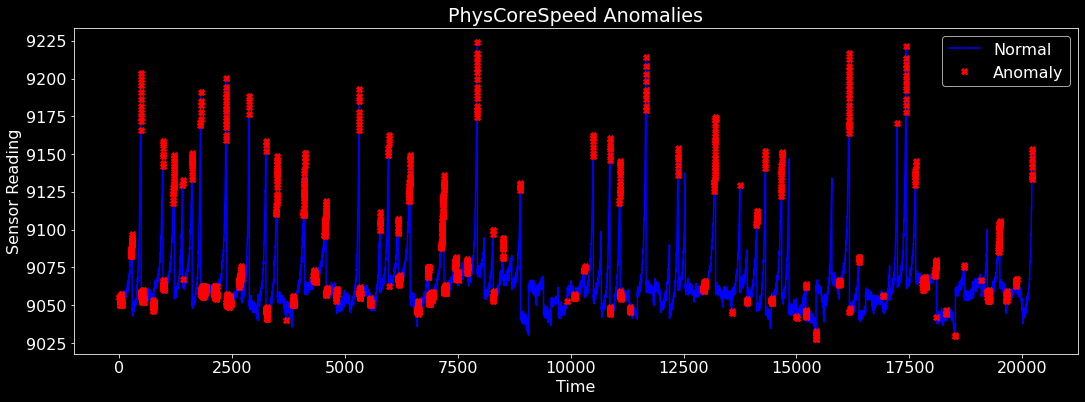

In [880]:
#Import necessary libraries
from sklearn.cluster import KMeans
# I will start k-means clustering with k=2 
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

# Assume that 10% of the entire data set are anomalies 
outliers_fraction = 0.10
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
print('No. of Anomalies detected : ',number_of_outliers )
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 

dfa['Kmeans_anomaly'] = (distance >= threshold).astype(int)

print(dfa['Kmeans_anomaly'].value_counts())

a = dfa.loc[dfa['Kmeans_anomaly'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(dfa['PhysCoreSpeed'], color='blue', label='Normal')
_ = plt.plot(a['PhysCoreSpeed'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('PhysCoreSpeed Anomalies')
_ = plt.legend(loc='best')
plt.show();

### 3. Isolation Forest

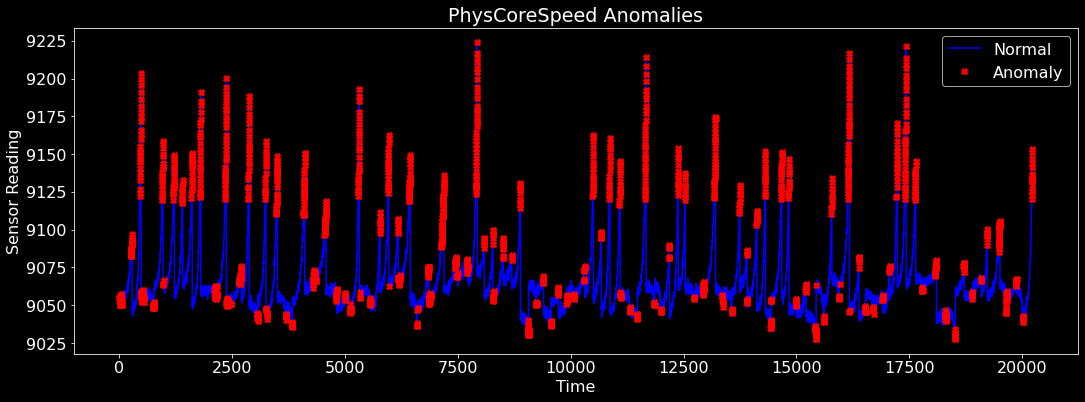

In [881]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
# Assume that 10% of the entire data set are anomalies
 
outliers_fraction = 0.10
model =  IsolationForest(contamination=outliers_fraction)
model.fit(dfa.values) 
dfa['IF_anomaly'] = pd.Series(model.predict(dfa.values))

# visualization
dfa['IF_anomaly'] = pd.Series(dfa['IF_anomaly'].values, index=dfa.index)
a = dfa.loc[dfa['IF_anomaly'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(dfa['PhysCoreSpeed'], color='blue', label='Normal')
_ = plt.plot(a['PhysCoreSpeed'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('PhysCoreSpeed Anomalies')
_ = plt.legend(loc='best')
plt.show();

In [886]:
## standardizing the anoamly values as 0 & 1
dfa.loc[dfa['IF_anomaly']== 1, 'IF_anomaly'] = 0
dfa.loc[dfa['IF_anomaly']== -1, 'IF_anomaly'] = 1

dfa['IF_anomaly'].value_counts()

0    18208
1     2023
Name: IF_anomaly, dtype: int64

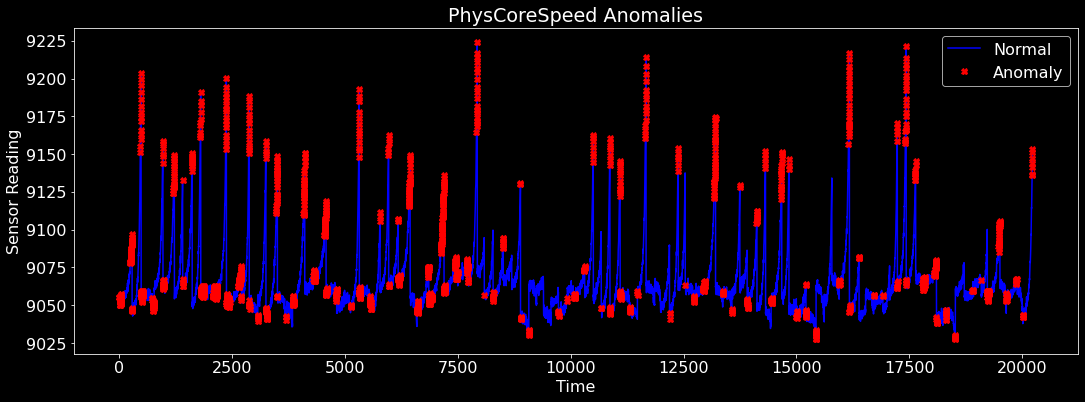

In [888]:
# Import OneClass SVM
from sklearn.svm import OneClassSVM
# Assume that 10% of the entire data set are anomalies
 
outliers_fraction = 0.10
model = OneClassSVM(nu=outliers_fraction)
model.fit(dfa.values) 
dfa['OneClassSVM_anomaly'] = pd.Series(model.predict(dfa.values))

# visualization
dfa['OneClassSVM_anomaly'] = pd.Series(dfa['OneClassSVM_anomaly'].values, index=dfa.index)
a = dfa.loc[dfa['OneClassSVM_anomaly'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(dfa['PhysCoreSpeed'], color='blue', label='Normal')
_ = plt.plot(a['PhysCoreSpeed'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
_ = plt.xlabel('Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('PhysCoreSpeed Anomalies')
_ = plt.legend(loc='best')
plt.show();

In [890]:
## standardizing the anoamly values as 0 & 1
dfa.loc[dfa['OneClassSVM_anomaly']== 1, 'OneClassSVM_anomaly'] = 0
dfa.loc[dfa['OneClassSVM_anomaly']== -1, 'OneClassSVM_anomaly'] = 1

dfa['OneClassSVM_anomaly'].value_counts()

0    18214
1     2017
Name: OneClassSVM_anomaly, dtype: int64

### 4. Auto Encoders

In [916]:
x=principalDf.iloc[:,:2]
y=principalDf.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)

# use case is novelty detection so use only the normal data
# for training
#train_index = y_train[y_train == 1].index
#train_data = x_train.loc[train_index]

# min max scale the input data
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())
x_scaled = min_max_scaler.fit_transform(x)
x_scaled

array([[0.89748036, 0.55233245],
       [0.89480078, 0.55190978],
       [0.891569  , 0.55210523],
       ...,
       [0.18667364, 0.44390721],
       [0.18271882, 0.44548315],
       [0.17888888, 0.44667898]])

In [917]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError


# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='relu')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='mse', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=50,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled))

Epoch 1/50
32/32 [==============================] - 2s 12ms/step - loss: 0.1167 - mse: 0.1167 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0370 - mse: 0.0370 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0090 - mse: 0.0

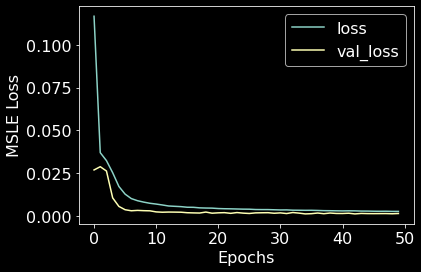

In [918]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [920]:
## Model Predictions
## Determine the reconstruction error values
test_x_predictions = model.predict(x_test_scaled)   
x_predictions = model.predict(x_scaled)     

test_mse = np.mean(np.power(x_test_scaled - test_x_predictions, 2), axis=1)     
test_error_df = pd.DataFrame({'Reconstruction_error': test_mse,     
                        'True_class': y_test})

X_mse = np.mean(np.power(x_scaled - x_predictions, 2), axis=1)     
X_error_df = pd.DataFrame({'Reconstruction_error': X_mse,     
                        'True_class': y})

print('test_mse : ', test_mse)
print('X MSE : ',X_mse)
print('test_error_df : ',test_error_df)


633/633 [==============================] - 1s 1ms/step
test_mse :  [1.13346046e-02 3.12689435e-04 6.11958230e-05 ... 1.36593295e-06
 3.14159092e-04 4.54788149e-03]
X MSE :  [0.0064793  0.00642705 0.00638436 ... 0.00067774 0.00070884 0.00074938]
test_error_df :         Reconstruction_error  True_class
6964               0.011335         227
12654              0.000313          77
5896               0.000061          70
11121              0.001542         202
343                0.000294         137
...                     ...         ...
2087               0.013812          73
16814              0.000296         101
8999               0.000001          72
8636               0.000314          57
560                0.004548         209

[4047 rows x 2 columns]


 Data distribution of test set 
  0    3710
1     337
dtype: int64
Number of anomaly samples in test set :  337




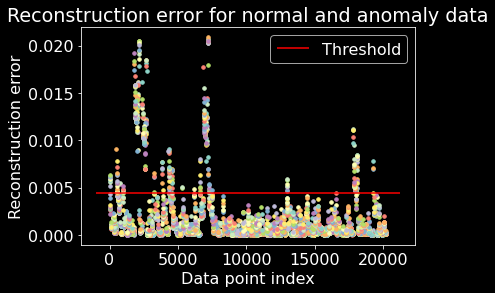

In [926]:
# finding out right threshold value in order to determin the anmoalies in the given test dataset

reconstruction_errors = tf.keras.losses.mse(test_x_predictions, x_test_scaled)
reconstruction_errors

threshold = np.mean(reconstruction_errors.numpy())  + np.std(reconstruction_errors.numpy())
threshold

errors = tf.keras.losses.mse(test_x_predictions, x_test_scaled)
anomaly_mask = pd.Series(errors) > threshold
preds = anomaly_mask.map(lambda x: 1 if x == True else 0)

print(' Data distribution of test set \n ',preds.value_counts())
print("Number of anomaly samples in test set : ", np.sum(preds))
#print("Indices of anomaly samples: ", np.where(preds))
print('\n')

# any readings above threshold value will be considered as anomaly
threshold_fixed = threshold  
groups = test_error_df.groupby('True_class')     
fig, ax = plt.subplots() 
for name, group in groups:     
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='')     
            #label= "Anomaly" if name == 1 else "Normal")     
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=200, label='Threshold')     
ax.legend()     
plt.title("Reconstruction error for normal and anomaly data")     
plt.ylabel("Reconstruction error")     
plt.xlabel("Data point index")     
plt.show()



 Data distribution of entire data set 
 0    18505
1     1726
dtype: int64
Number of anomaly samples in entire dataset:  1726


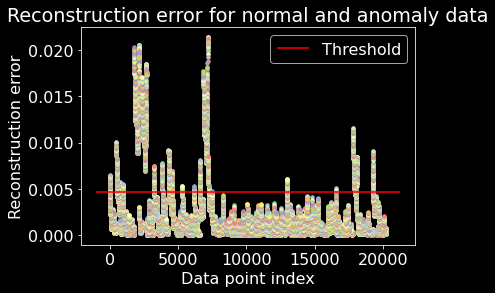

In [927]:
# finding out right threshold value in order to determin the anmoalies in the given entire dataset
reconstruction_errors = tf.keras.losses.mse(x_predictions, x_scaled)
threshold = np.mean(reconstruction_errors.numpy())  + np.std(reconstruction_errors.numpy())
errors = tf.keras.losses.mse(x_predictions, x_scaled)
anomaly_mask = pd.Series(errors) > threshold
preds = anomaly_mask.map(lambda x: 1 if x == True else 0)

print(' Data distribution of entire data set \n',preds.value_counts())
print("Number of anomaly samples in entire dataset: ", np.sum(preds))
#print("Indices of anomaly samples: ", np.where(preds))

# any readings above threshold value will be considered as anomaly
threshold_fixed = threshold  
groups = X_error_df.groupby('True_class')     
fig, ax = plt.subplots() 
for name, group in groups:     
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='')     
            #label= "Anomaly" if name == 1 else "Normal")     
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=200, label='Threshold')     
ax.legend()     
plt.title("Reconstruction error for normal and anomaly data")     
plt.ylabel("Reconstruction error")     
plt.xlabel("Data point index")     
plt.show()

In [929]:
dfa['auto_enocder_anomaly']= preds
dfa

,Unit,Time,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,remaining_cycle,IQR_anomaly,Kmeans_anomaly,IF_anomaly,OneClassSVM_anomaly,auto_enocder_anomaly
0,2,5,641.734,1584.478,1396.394,554.762,2388.008,9055.286,8.39518,391.0,39.084,23.44362,282,0,1,1,1,1
1,2,6,641.616,1583.210,1397.490,554.852,2388.014,9055.156,8.39308,391.2,39.126,23.43732,281,0,1,1,1,1
2,2,7,641.658,1583.298,1398.994,554.866,2388.028,9055.428,8.38856,391.0,39.134,23.44998,280,0,1,1,1,1
3,2,8,641.858,1583.716,1398.280,554.768,2388.022,9055.744,8.38974,391.0,39.134,23.45260,279,0,1,1,1,1
4,2,9,641.918,1583.284,1398.066,554.856,2388.030,9054.476,8.38674,390.8,39.120,23.44956,278,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20226,71,204,643.412,1600.718,1430.276,551.716,2388.128,9141.576,8.51390,396.6,38.526,23.03768,4,1,1,1,1,0
20227,71,205,643.552,1602.200,1428.934,551.774,2388.128,9143.782,8.51514,396.6,38.528,23.06698,3,1,1,1,1,0
20228,71,206,643.568,1601.592,1429.728,551.776,2388.138,9147.260,8.52370,396.4,38.516,23.08974,2,1,1,1,1,0
20229,71,207,643.560,1600.980,1430.362,551.678,2388.140,9151.368,8.52834,396.4,38.506,23.10416,1,1,1,1,1,0


In [938]:
## Considering predictions of all models and final output based upon majority voting 
for i in range(len(dfa)):
    dfa.loc[i,'final_anomaly_pred']= [1 if dfa.loc[i,'IQR_anomaly':'auto_enocder_anomaly'].mean()>0.6 else 0]

In [940]:
## In total, 770 are considered as true anomalies that underlie in the given dataset.
dfa['final_anomaly_pred'].value_counts()

0.0    19471
1.0      760
Name: final_anomaly_pred, dtype: int64

## Conclusion

1. In terms of RUL prediction, we tried with different models such as Linear Regression, Lasso, Ridge, Random Forest and XGBoost regression.

Out of which, RF regressor performs very well (verified with cross validation) since it has high R-Squared and low RMSE compared to other models.

Performed feature importance to understand important features for the model predicitons.

Additionaly, in terms of feature engineering,

 we could have tried moving average, fft, and other statistical/temporal/spectral features extraction.
 
But, with current approach we're able to obtain the desirable results.





2. In terms of anomaly detection, we tried with different approaches such as IQR, Once class SVM, K-Means, Isolation Forest and auto encoders.

Here, to make the predictions more robust, we didn't simply rely on one model results. Instead, we took a majority voting of all models prediction.

This could results us a better relaible predictions.


